In [1]:
import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pandas_ml
from pandas_ml import ConfusionMatrix

In [2]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_var5_var6" #change the path to your dataset folder here
DATASET_TEST_PATH = "/home/dic/jupyter/train_var5_var6"

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=80)
 
    #we want to use a 15% validation split
    total_len=len(images)
    print("total:",total_len)
    vsplit = int(len(images) * 0.80) #=40
    print("vsplit:",vsplit)
    
    tsplit= int(total_len-vsplit)
    print("tsplit:",tsplit)
    
    gsplit=int(tsplit/2)
    print(gsplit)
    msplit=int(vsplit+gsplit)
    
    
    train = images[:vsplit] #everything except the last vsplit items in the array 
    val = images[vsplit:msplit]  #only last vsplit items from the array
    test=images[msplit:]
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
    print ("TEST IMAGES:", len(test))
    return classes, train, val,test
 
#parse dataset
CLASSES, TRAIN, VAL,TEST = parseDataset()


total: 5932
vsplit: 4745
tsplit: 1187
593
CLASS LABELS: ['var5', 'var6']
TRAINING IMAGES: 4745
VALIDATION IMAGES: 593
TEST IMAGES: 594


In [3]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [4]:
import os
import time
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

from lasagne import random as lasagne_random
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
from lasagne import objectives
from lasagne import updates

import theano
import theano.tensor as T

import warnings
warnings.filterwarnings("ignore")


In [5]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=64, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_pool = layers.MaxPool2DLayer(l_conv2, pool_size=2)
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_pool, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 593346 PARAMS


In [6]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [7]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [8]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0002)

In [9]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [10]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    img = np.transpose(img, (2, 1, 0))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((2), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 2)
 
    return img, target

In [11]:
#a reasonable size for one batch is 128
BATCH_SIZE = 300
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

In [12]:

        
def getNextImageBatch1(split=TEST):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_T = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_T = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        iT = 0
        for path in chunk:
            #load image data and class label from path
            x1, y1 = loadImageAndTarget(path)
 
            #pack into batch array
            x_T[iT] = x1
            y_T[iT] = y1
            iT += 1
 
        #instead of return, we use yield
        yield x_T[:len(chunk)], y_T[:len(chunk)]

In [13]:
cmatrix = []
def clearConfusionMatrix():

    global cmatrix

    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
    
    
def updateConfusionMatrix(t, p):
    
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
    
def showConfusionMatrix():

    #new figure
    plt.figure(1)
    plt.clf()

    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)

    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")

    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')

    #show
    plt.show()
    plt.pause(0.5)   


In [14]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

START TRAINING...
EPOCH: 1
TRAIN LOSS: 2.6377156443169527
VAL LOSS: 1.075437618779944
VAL ACCURACY: 90.2 %
TIME: 30.8 s


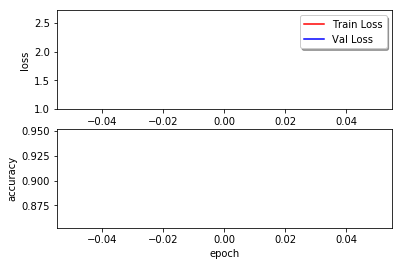

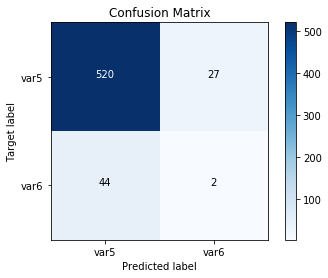

EPOCH: 2
TRAIN LOSS: 0.6847617255212557
VAL LOSS: 0.3989959394452978
VAL ACCURACY: 89.0 %
TIME: 34.2 s


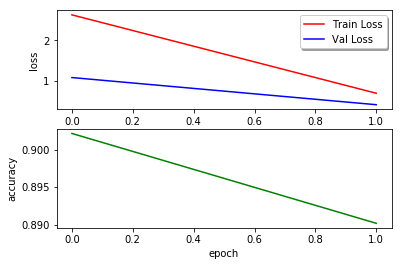

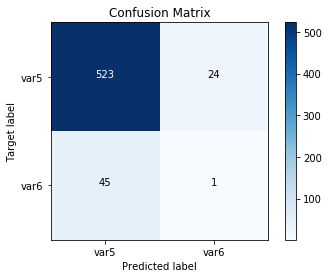

EPOCH: 3
TRAIN LOSS: 0.40538547585047646
VAL LOSS: 0.35447419457873774
VAL ACCURACY: 88.1 %
TIME: 28.9 s


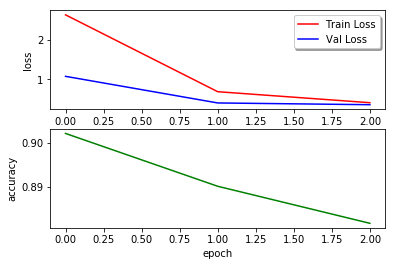

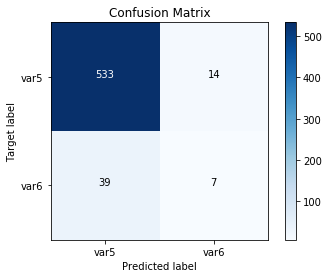

EPOCH: 4
TRAIN LOSS: 0.32084812957313436
VAL LOSS: 0.2881446920079701
VAL ACCURACY: 90.7 %
TIME: 29.8 s


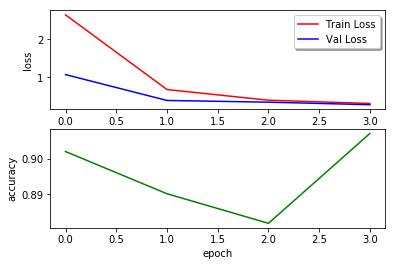

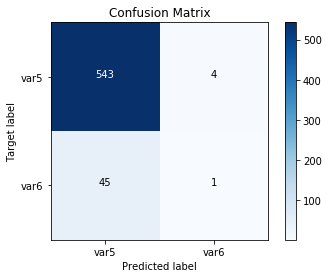

EPOCH: 5
TRAIN LOSS: 0.2879099938310226
VAL LOSS: 0.24592798611521505
VAL ACCURACY: 91.8 %
TIME: 29.9 s


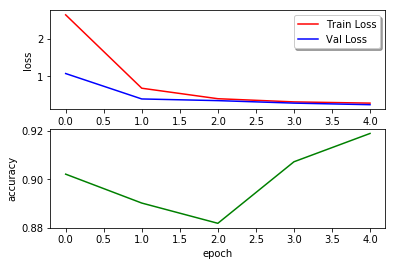

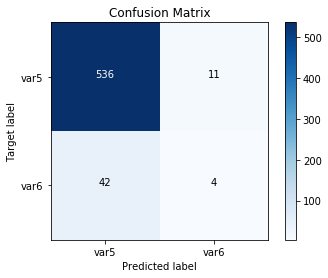

EPOCH: 6
TRAIN LOSS: 0.27551140323127066
VAL LOSS: 0.26399520729265646
VAL ACCURACY: 91.9 %
TIME: 29.2 s


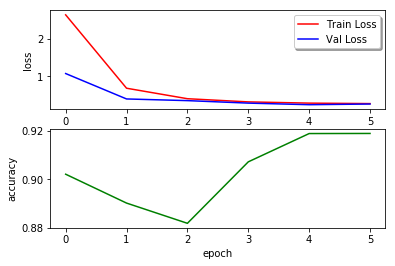

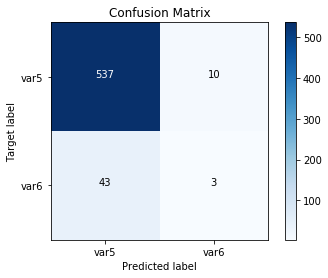

EPOCH: 7
TRAIN LOSS: 0.2532741094859742
VAL LOSS: 0.24220522444564152
VAL ACCURACY: 92.0 %
TIME: 29.8 s


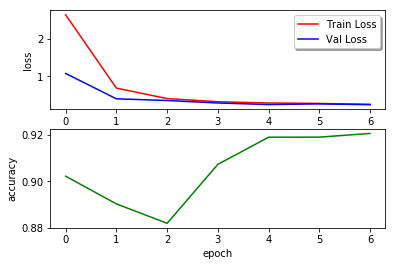

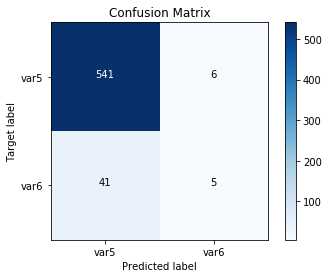

EPOCH: 8
TRAIN LOSS: 0.2519244793204997
VAL LOSS: 0.2264865888406147
VAL ACCURACY: 91.8 %
TIME: 29.3 s


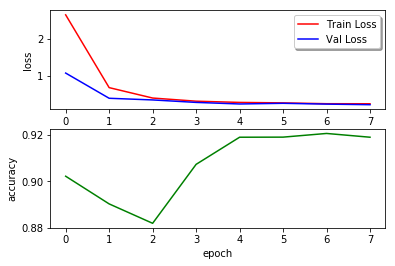

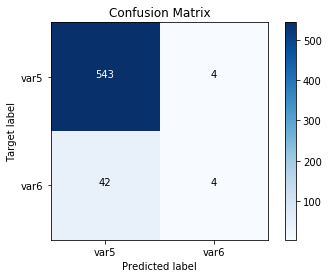

EPOCH: 9
TRAIN LOSS: 0.2380921718138319
VAL LOSS: 0.20455322342571108
VAL ACCURACY: 92.5 %
TIME: 28.3 s


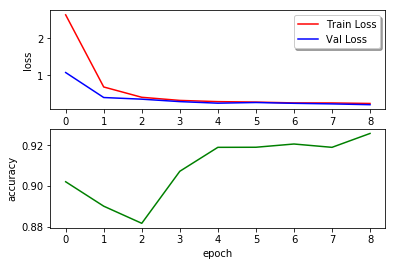

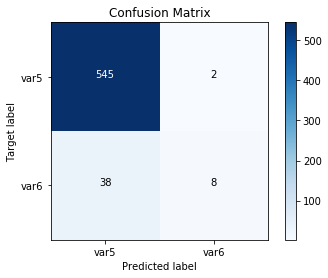

EPOCH: 10
TRAIN LOSS: 0.22112966182031074
VAL LOSS: 0.19277124957984565
VAL ACCURACY: 92.7 %
TIME: 30.8 s


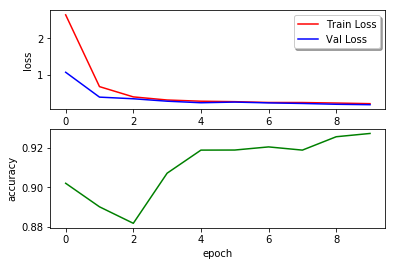

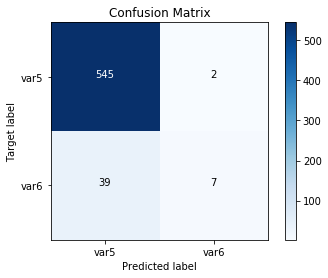

EPOCH: 11
TRAIN LOSS: 0.20968443874030604
VAL LOSS: 0.17662916634896414
VAL ACCURACY: 93.2 %
TIME: 31.4 s


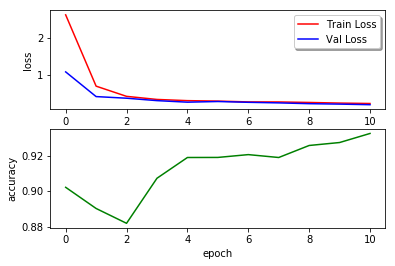

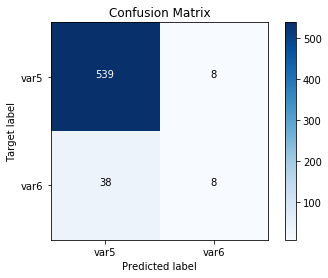

EPOCH: 12
TRAIN LOSS: 0.20753241464552669
VAL LOSS: 0.15143315791604428
VAL ACCURACY: 93.9 %
TIME: 28.9 s


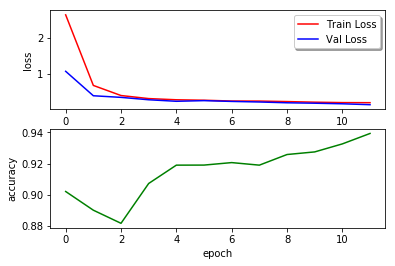

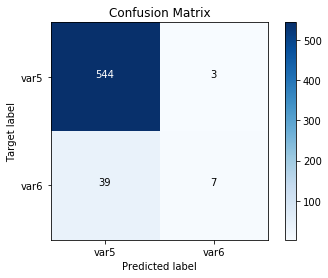

EPOCH: 13
TRAIN LOSS: 0.19981050805345169
VAL LOSS: 0.1630540828110761
VAL ACCURACY: 93.7 %
TIME: 28.3 s


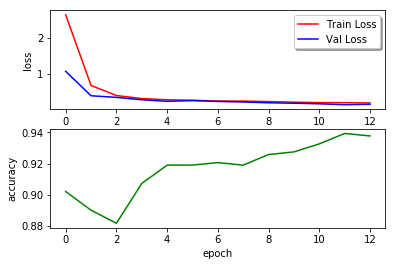

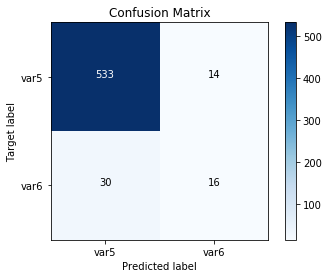

EPOCH: 14
TRAIN LOSS: 0.19339473662947354
VAL LOSS: 0.17591170483840685
VAL ACCURACY: 92.5 %
TIME: 30.0 s


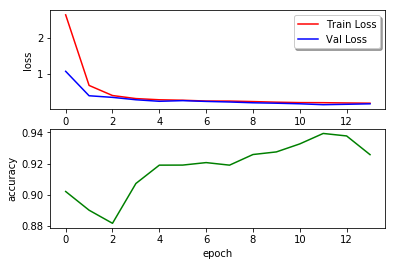

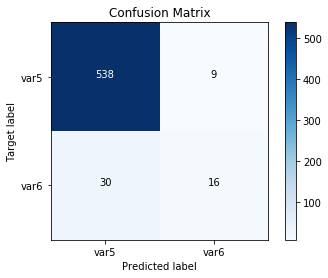

EPOCH: 15
TRAIN LOSS: 0.18015526640193477
VAL LOSS: 0.14929060793625418
VAL ACCURACY: 94.2 %
TIME: 29.5 s


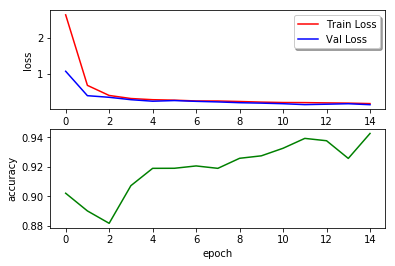

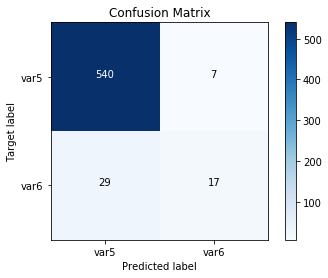

EPOCH: 16
TRAIN LOSS: 0.1610729435116036
VAL LOSS: 0.1401126831731646
VAL ACCURACY: 95.1 %
TIME: 29.9 s


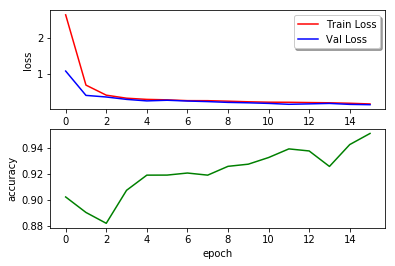

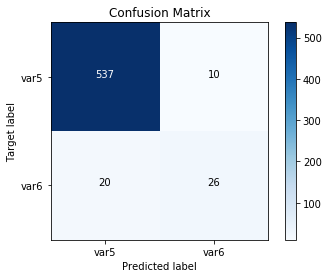

EPOCH: 17
TRAIN LOSS: 0.16236437006031412
VAL LOSS: 0.1286546969020554
VAL ACCURACY: 94.9 %
TIME: 28.8 s


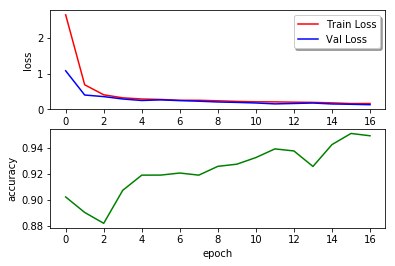

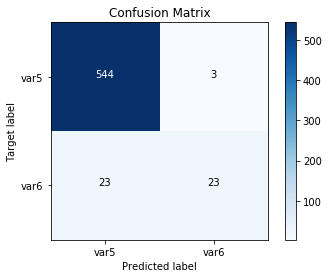

EPOCH: 18
TRAIN LOSS: 0.15407042135797394
VAL LOSS: 0.1463352298471341
VAL ACCURACY: 94.4 %
TIME: 29.2 s


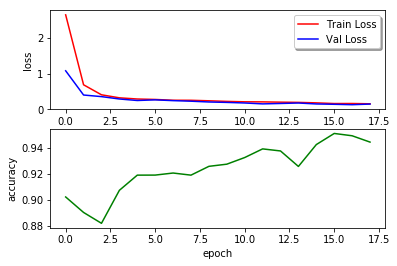

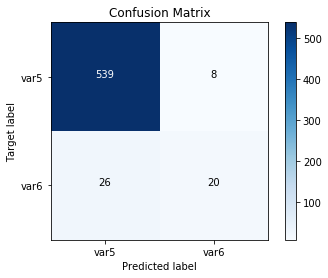

EPOCH: 19
TRAIN LOSS: 0.15124722167461227
VAL LOSS: 0.11768879461632961
VAL ACCURACY: 95.6 %
TIME: 30.0 s


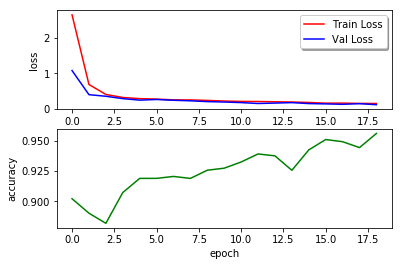

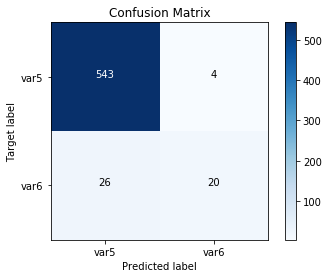

EPOCH: 20
TRAIN LOSS: 0.1536809816795538
VAL LOSS: 0.12083274140722146
VAL ACCURACY: 94.9 %
TIME: 28.5 s


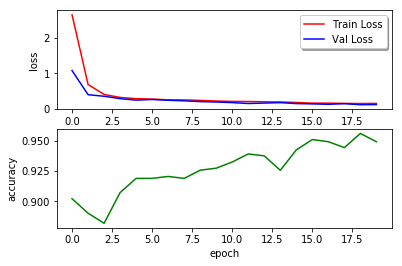

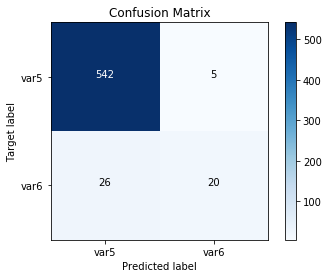

EPOCH: 21
TRAIN LOSS: 0.13966403057173649
VAL LOSS: 0.1436013669353442
VAL ACCURACY: 93.9 %
TIME: 29.3 s


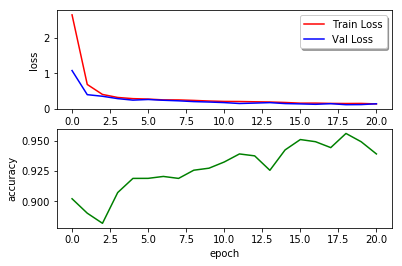

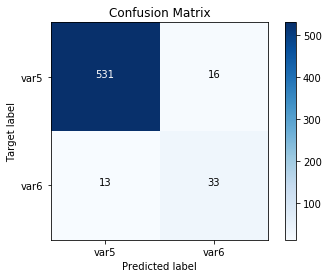

EPOCH: 22
TRAIN LOSS: 0.14122310657283366
VAL LOSS: 0.12509896710336996
VAL ACCURACY: 95.2 %
TIME: 28.0 s


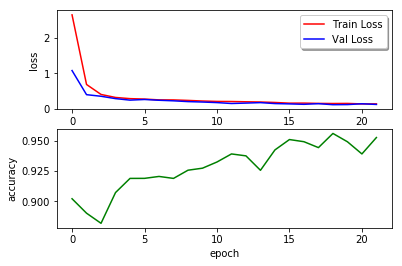

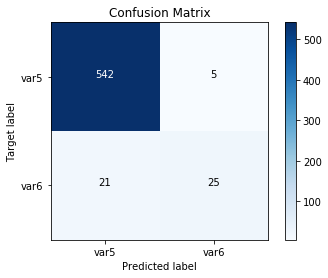

EPOCH: 23
TRAIN LOSS: 0.13573457267058464
VAL LOSS: 0.10394201361749347
VAL ACCURACY: 95.7 %
TIME: 29.3 s


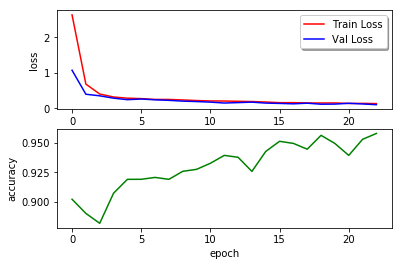

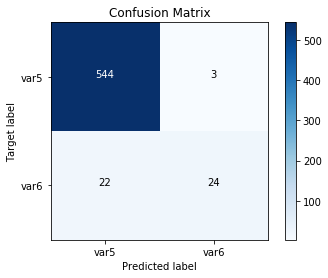

EPOCH: 24
TRAIN LOSS: 0.12660359105233376
VAL LOSS: 0.09861860305518685
VAL ACCURACY: 96.4 %
TIME: 28.5 s


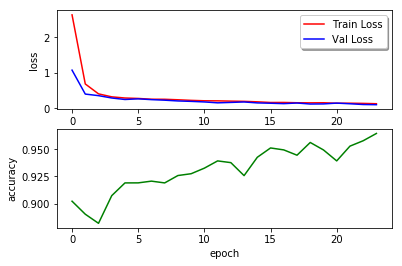

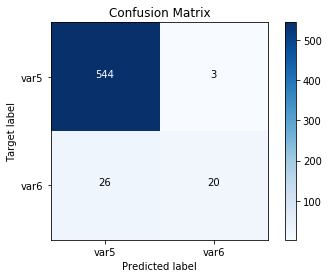

EPOCH: 25
TRAIN LOSS: 0.11963908867631996
VAL LOSS: 0.09762697147958135
VAL ACCURACY: 96.2 %
TIME: 28.6 s


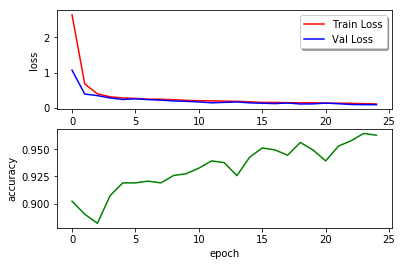

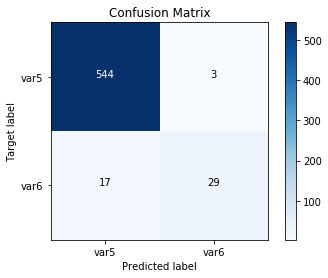

EPOCH: 26
TRAIN LOSS: 0.12990670379182523
VAL LOSS: 0.09626814036604774
VAL ACCURACY: 95.9 %
TIME: 28.1 s


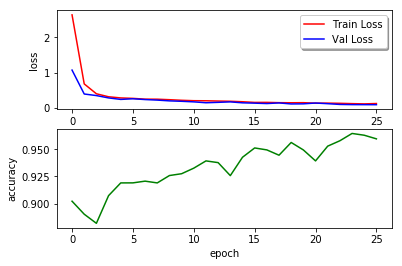

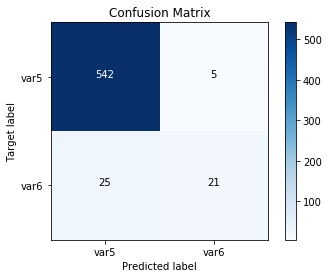

EPOCH: 27
TRAIN LOSS: 0.12752243053718398
VAL LOSS: 0.11057324637530949
VAL ACCURACY: 96.6 %
TIME: 27.4 s


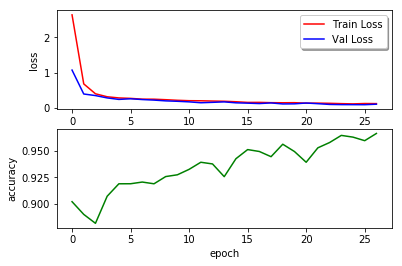

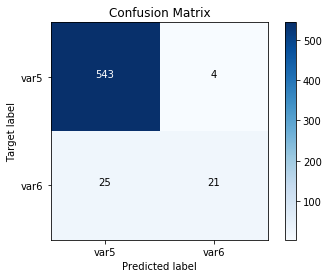

EPOCH: 28
TRAIN LOSS: 0.12348487868816346
VAL LOSS: 0.10876945544488839
VAL ACCURACY: 95.4 %
TIME: 28.5 s


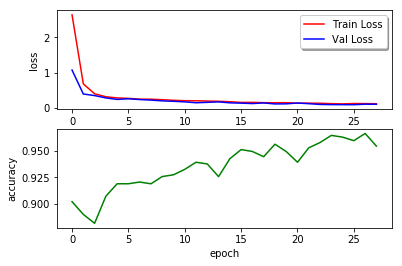

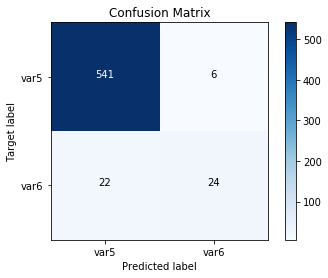

EPOCH: 29
TRAIN LOSS: 0.11368917080915461
VAL LOSS: 0.1128850532382959
VAL ACCURACY: 96.1 %
TIME: 27.9 s


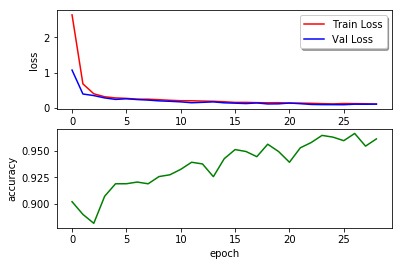

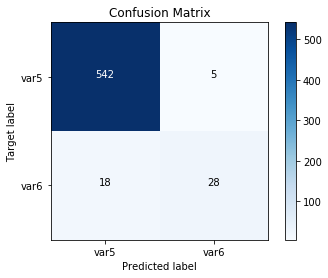

EPOCH: 30
TRAIN LOSS: 0.1126923808261138
VAL LOSS: 0.10259541495347951
VAL ACCURACY: 96.7 %
TIME: 31.8 s


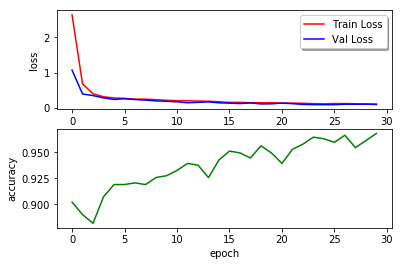

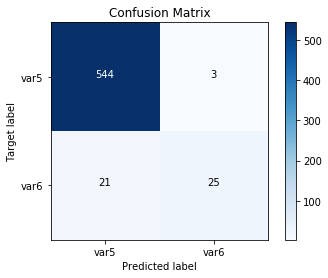

EPOCH: 31
TRAIN LOSS: 0.1258687222072427
VAL LOSS: 0.12018513945898035
VAL ACCURACY: 96.2 %
TIME: 27.8 s


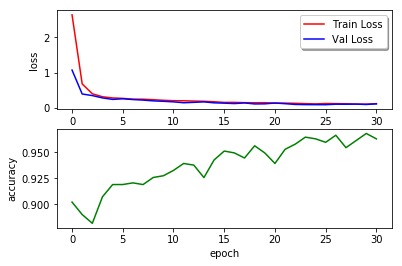

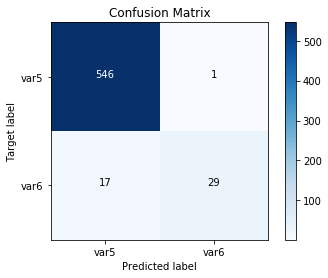

EPOCH: 32
TRAIN LOSS: 0.10476384315817933
VAL LOSS: 0.09130986328780075
VAL ACCURACY: 97.2 %
TIME: 27.4 s


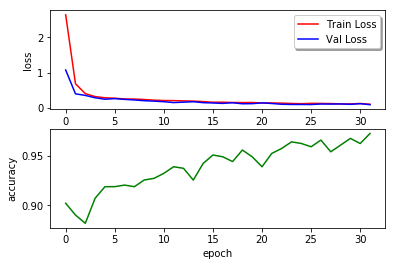

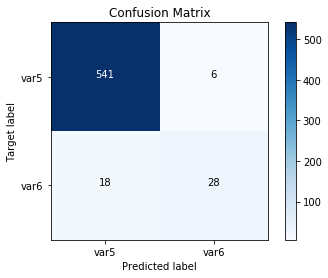

EPOCH: 33
TRAIN LOSS: 0.10735010217627639
VAL LOSS: 0.1022833682231604
VAL ACCURACY: 96.1 %
TIME: 28.2 s


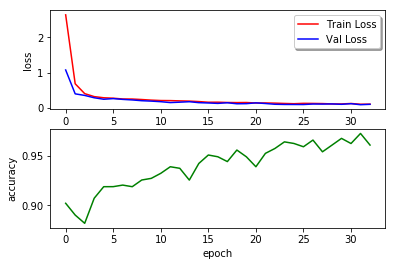

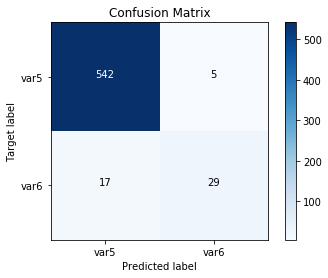

EPOCH: 34
TRAIN LOSS: 0.10168857038797097
VAL LOSS: 0.08504600801953234
VAL ACCURACY: 96.6 %
TIME: 29.0 s


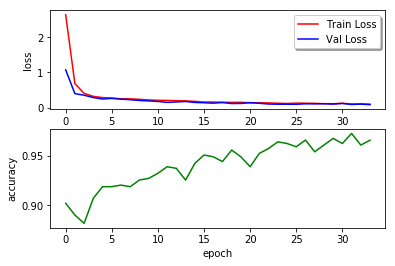

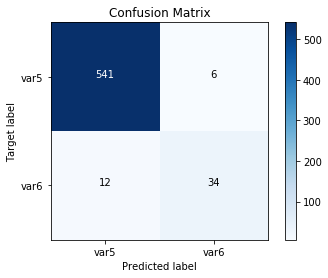

EPOCH: 35
TRAIN LOSS: 0.0987730337152007
VAL LOSS: 0.09905308118700812
VAL ACCURACY: 95.7 %
TIME: 28.1 s


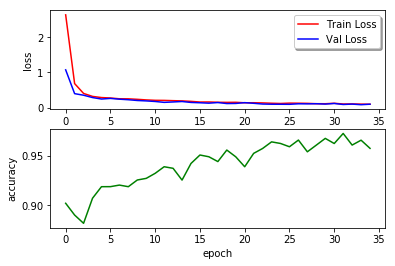

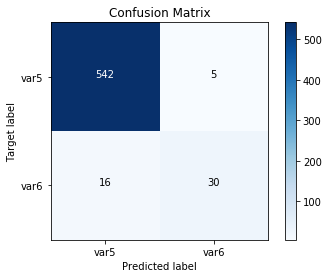

EPOCH: 36
TRAIN LOSS: 0.10987294096664112
VAL LOSS: 0.0858788930400492
VAL ACCURACY: 96.6 %
TIME: 27.7 s


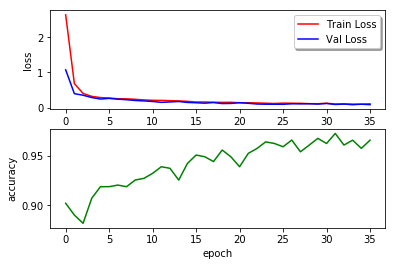

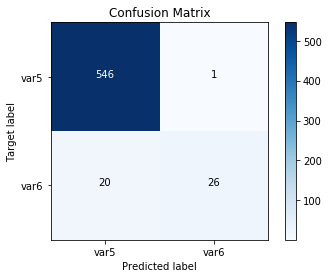

EPOCH: 37
TRAIN LOSS: 0.09350823099878552
VAL LOSS: 0.11834868814692046
VAL ACCURACY: 96.1 %
TIME: 29.0 s


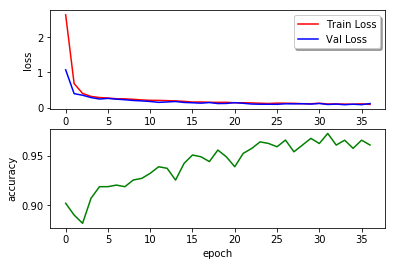

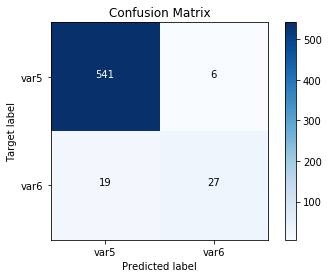

EPOCH: 38
TRAIN LOSS: 0.09961311715185331
VAL LOSS: 0.08533351208525294
VAL ACCURACY: 96.6 %
TIME: 28.2 s


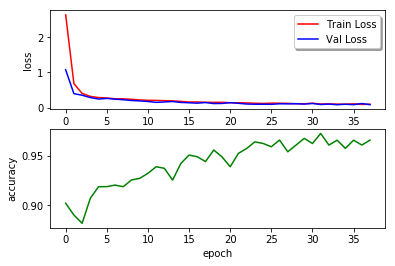

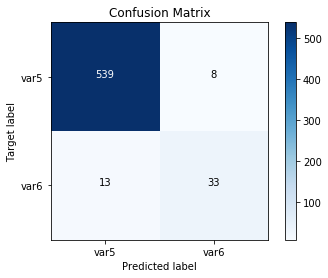

EPOCH: 39
TRAIN LOSS: 0.09428396922191865
VAL LOSS: 0.08591358984148346
VAL ACCURACY: 97.6 %
TIME: 28.5 s


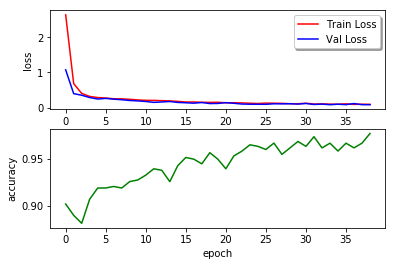

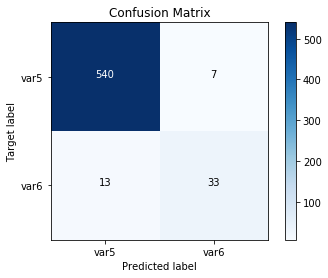

EPOCH: 40
TRAIN LOSS: 0.09248833415318145
VAL LOSS: 0.07556599784244628
VAL ACCURACY: 97.4 %
TIME: 28.9 s


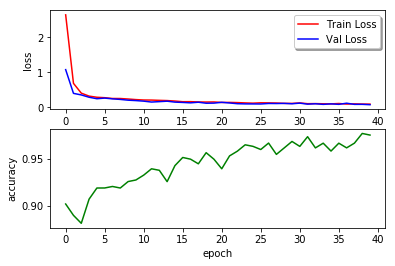

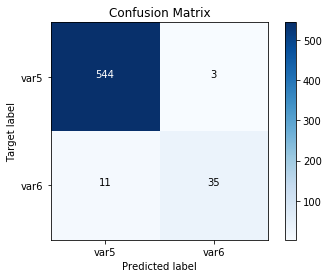

EPOCH: 41
TRAIN LOSS: 0.09611295260322499
VAL LOSS: 0.09944540698801538
VAL ACCURACY: 97.1 %
TIME: 29.3 s


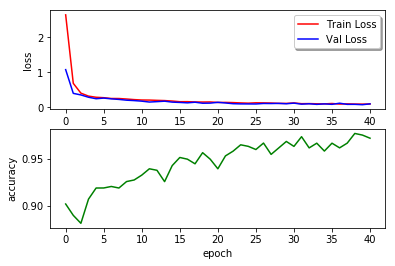

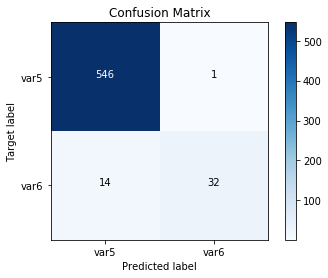

EPOCH: 42
TRAIN LOSS: 0.08960381343969803
VAL LOSS: 0.11160983360000144
VAL ACCURACY: 96.1 %
TIME: 30.3 s


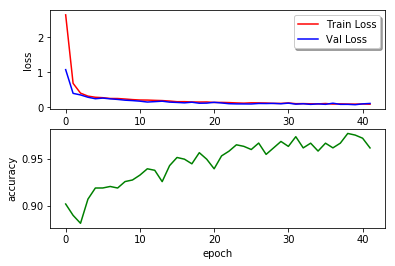

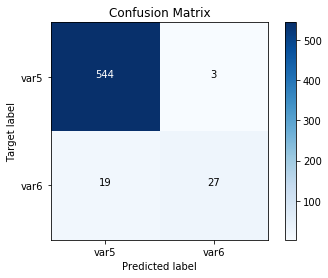

EPOCH: 43
TRAIN LOSS: 0.12148587905634174
VAL LOSS: 0.11087438825106866
VAL ACCURACY: 96.4 %
TIME: 30.8 s


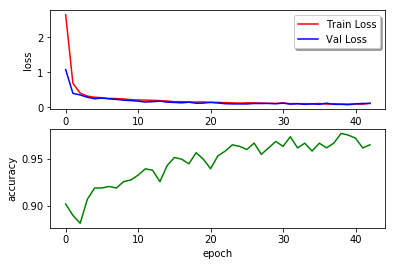

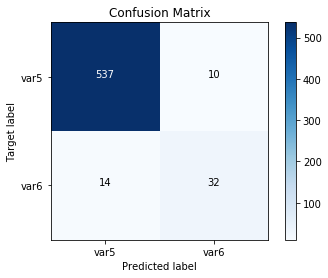

EPOCH: 44
TRAIN LOSS: 0.09404859949422445
VAL LOSS: 0.07668447233829967
VAL ACCURACY: 97.8 %
TIME: 29.0 s


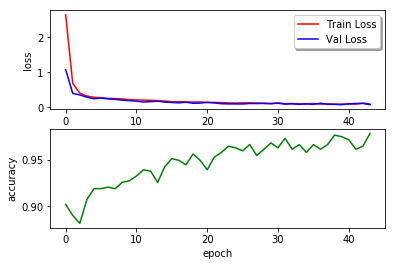

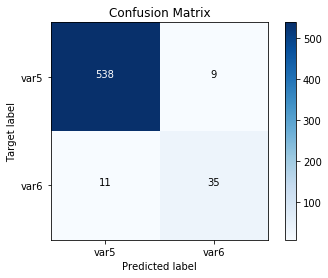

EPOCH: 45
TRAIN LOSS: 0.08959695524321651
VAL LOSS: 0.09623418984241125
VAL ACCURACY: 96.6 %
TIME: 30.5 s


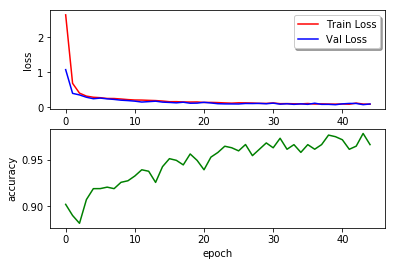

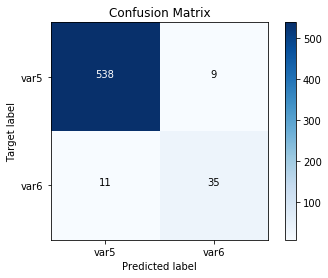

EPOCH: 46
TRAIN LOSS: 0.08816637465661234
VAL LOSS: 0.07709169964503948
VAL ACCURACY: 98.4 %
TIME: 28.7 s


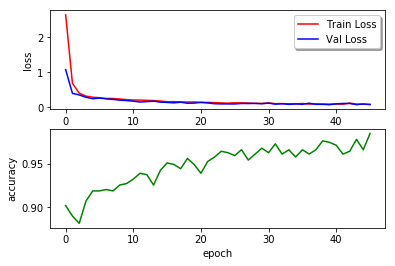

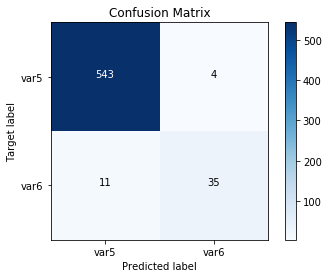

EPOCH: 47
TRAIN LOSS: 0.08311295207177774
VAL LOSS: 0.08552486055749925
VAL ACCURACY: 96.2 %
TIME: 29.0 s


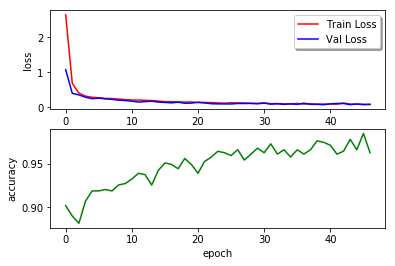

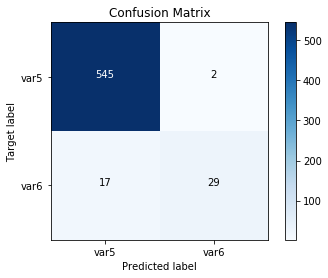

EPOCH: 48
TRAIN LOSS: 0.08092906793460633
VAL LOSS: 0.10649847619812033
VAL ACCURACY: 96.8 %
TIME: 29.1 s


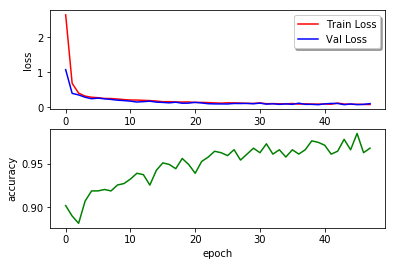

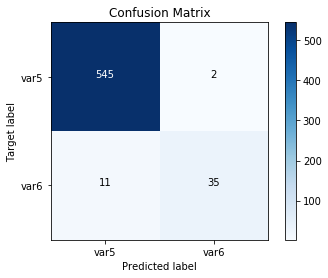

EPOCH: 49
TRAIN LOSS: 0.08351989026518564
VAL LOSS: 0.0786905824250709
VAL ACCURACY: 97.2 %
TIME: 28.2 s


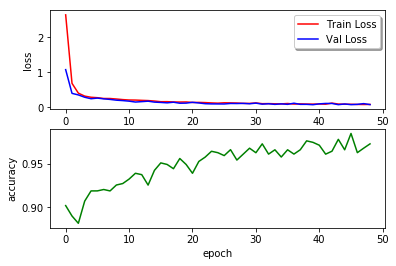

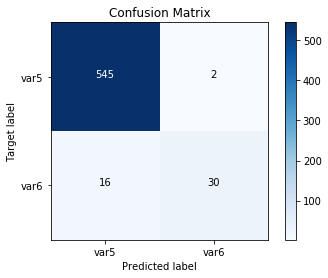

EPOCH: 50
TRAIN LOSS: 0.08620067330786216
VAL LOSS: 0.08598987702514765
VAL ACCURACY: 96.9 %
TIME: 28.9 s


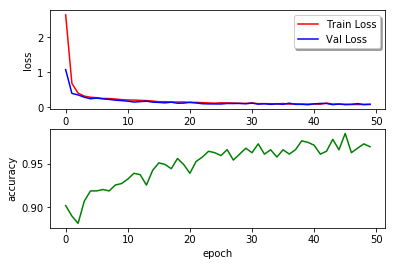

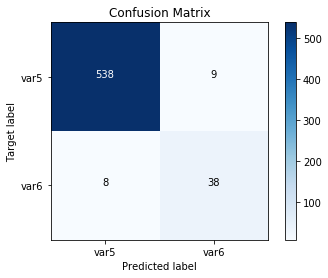

EPOCH: 51
TRAIN LOSS: 0.07753609015366875
VAL LOSS: 0.10032123295249172
VAL ACCURACY: 96.2 %
TIME: 30.0 s


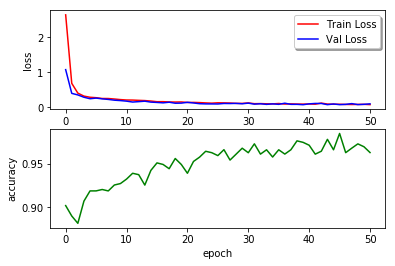

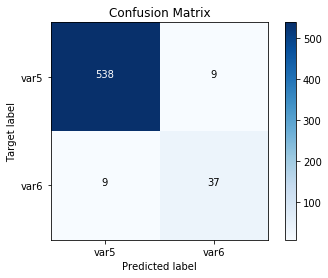

EPOCH: 52
TRAIN LOSS: 0.07537366530925416
VAL LOSS: 0.07493995164015632
VAL ACCURACY: 97.6 %
TIME: 30.9 s


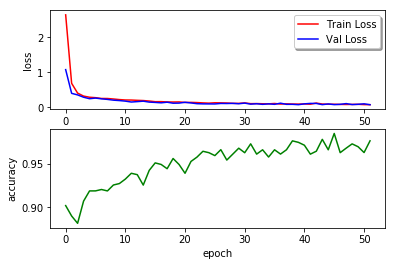

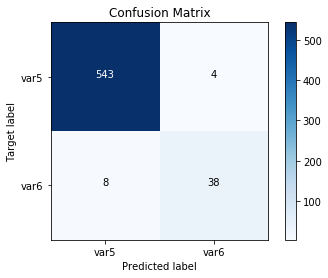

EPOCH: 53
TRAIN LOSS: 0.07806061807464942
VAL LOSS: 0.07752814498543001
VAL ACCURACY: 97.6 %
TIME: 28.2 s


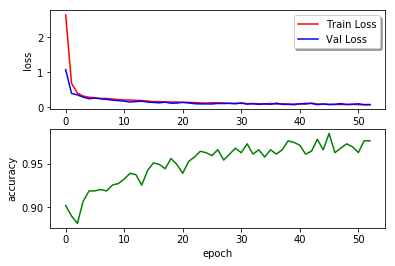

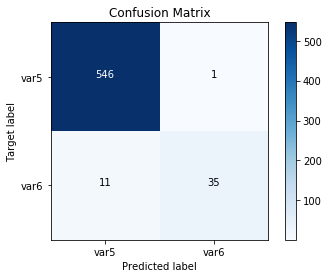

EPOCH: 54
TRAIN LOSS: 0.0776403190382872
VAL LOSS: 0.08830837125176871
VAL ACCURACY: 97.3 %
TIME: 27.6 s


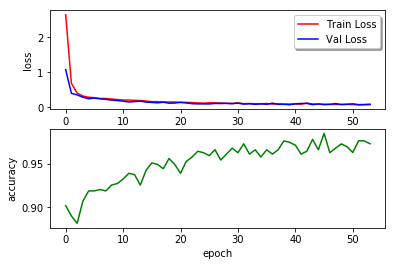

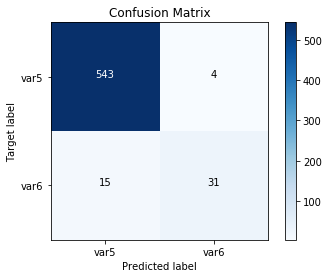

EPOCH: 55
TRAIN LOSS: 0.07165303898053946
VAL LOSS: 0.0619479896046613
VAL ACCURACY: 98.3 %
TIME: 28.2 s


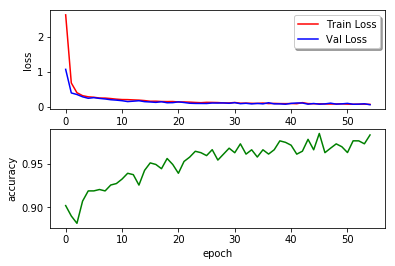

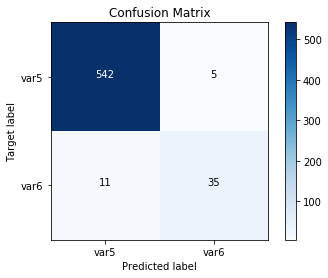

EPOCH: 56
TRAIN LOSS: 0.07295802055021887
VAL LOSS: 0.08496070033599731
VAL ACCURACY: 97.4 %
TIME: 27.4 s


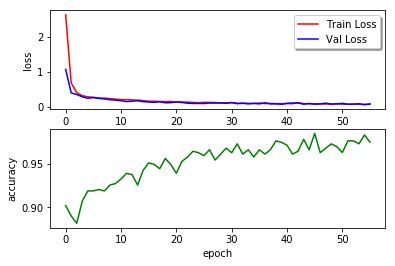

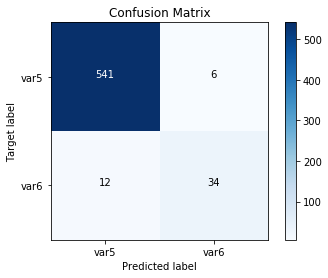

EPOCH: 57
TRAIN LOSS: 0.07428614112885448
VAL LOSS: 0.0879508513266016
VAL ACCURACY: 97.8 %
TIME: 30.8 s


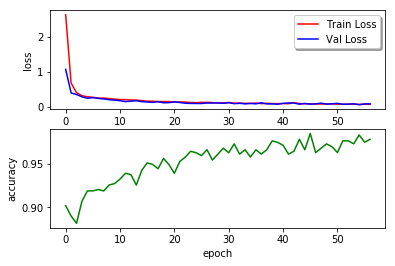

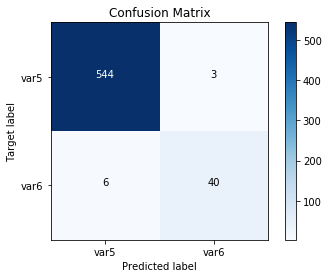

EPOCH: 58
TRAIN LOSS: 0.0668552506836757
VAL LOSS: 0.06443296233384249
VAL ACCURACY: 98.8 %
TIME: 28.4 s


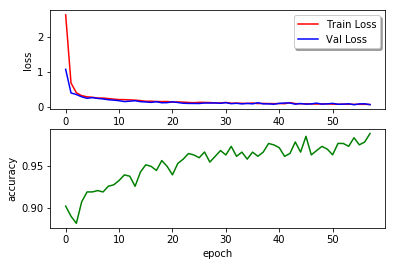

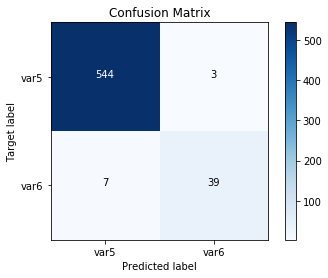

EPOCH: 59
TRAIN LOSS: 0.06369320405958034
VAL LOSS: 0.07469924409929324
VAL ACCURACY: 97.9 %
TIME: 29.0 s


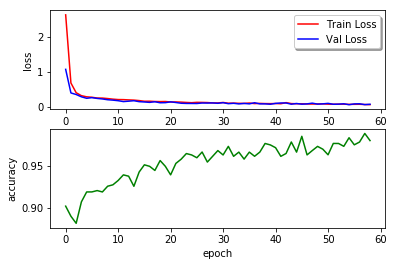

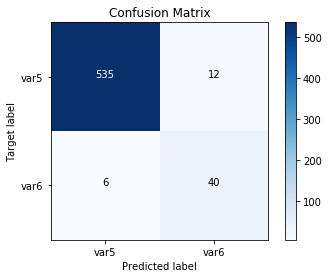

EPOCH: 60
TRAIN LOSS: 0.06889299382248429
VAL LOSS: 0.08369130705655553
VAL ACCURACY: 97.4 %
TIME: 29.2 s


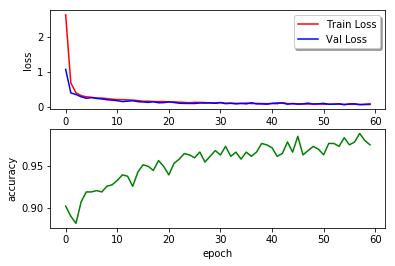

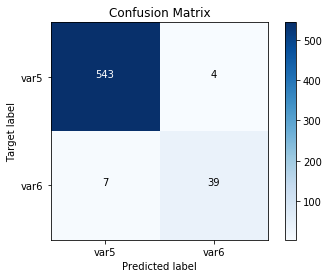

EPOCH: 61
TRAIN LOSS: 0.06276568911427001
VAL LOSS: 0.09051884522233881
VAL ACCURACY: 97.4 %
TIME: 30.1 s


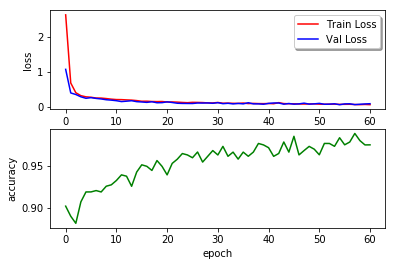

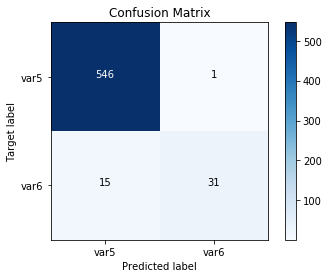

EPOCH: 62
TRAIN LOSS: 0.07120777692079162
VAL LOSS: 0.05322214519462863
VAL ACCURACY: 98.3 %
TIME: 29.8 s


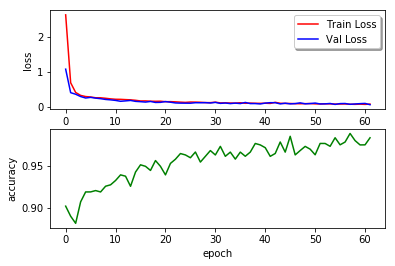

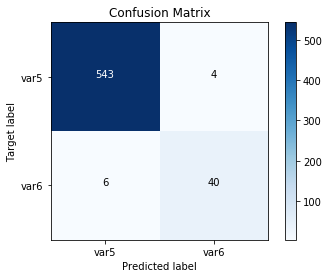

EPOCH: 63
TRAIN LOSS: 0.08038716177170607
VAL LOSS: 0.11949973084649103
VAL ACCURACY: 96.9 %
TIME: 31.0 s


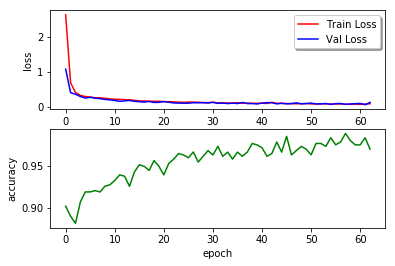

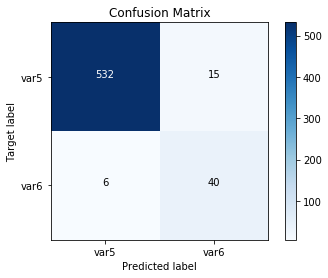

EPOCH: 64
TRAIN LOSS: 0.07069349293437147
VAL LOSS: 0.0783421516994273
VAL ACCURACY: 97.3 %
TIME: 29.9 s


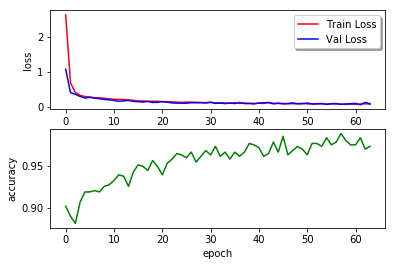

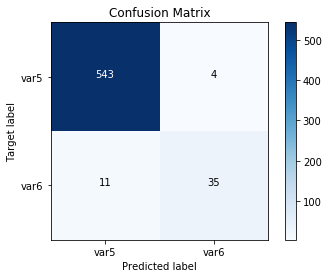

EPOCH: 65
TRAIN LOSS: 0.058332401944567416
VAL LOSS: 0.07913588174031366
VAL ACCURACY: 97.8 %
TIME: 29.9 s


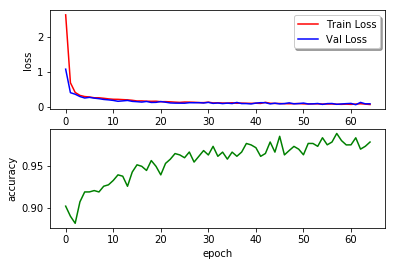

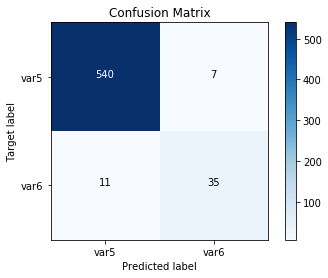

EPOCH: 66
TRAIN LOSS: 0.063301056757079
VAL LOSS: 0.07433061773362758
VAL ACCURACY: 97.8 %
TIME: 23.2 s


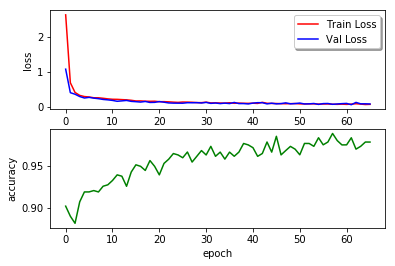

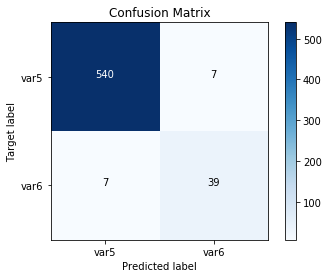

EPOCH: 67
TRAIN LOSS: 0.059998652547770856
VAL LOSS: 0.06660876411855864
VAL ACCURACY: 97.6 %
TIME: 15.3 s


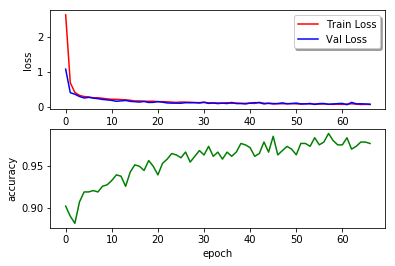

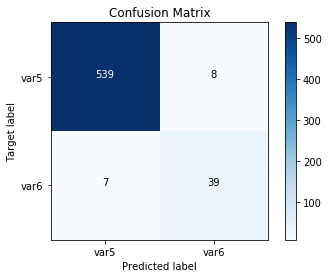

EPOCH: 68
TRAIN LOSS: 0.061370094158181676
VAL LOSS: 0.08673874703476442
VAL ACCURACY: 98.1 %
TIME: 15.4 s


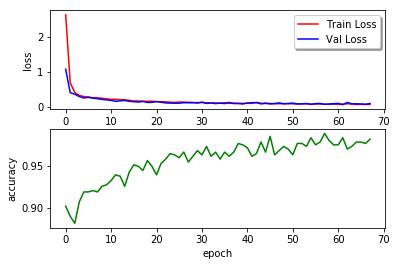

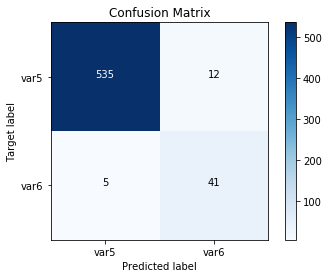

EPOCH: 69
TRAIN LOSS: 0.05929923241610184
VAL LOSS: 0.08455633596642158
VAL ACCURACY: 97.6 %
TIME: 15.6 s


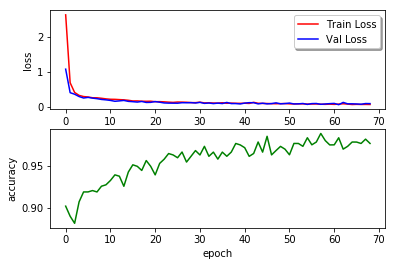

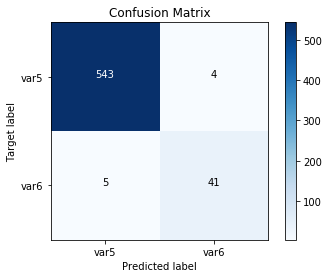

EPOCH: 70
TRAIN LOSS: 0.05080563920758119
VAL LOSS: 0.0770334541356972
VAL ACCURACY: 97.8 %
TIME: 14.8 s


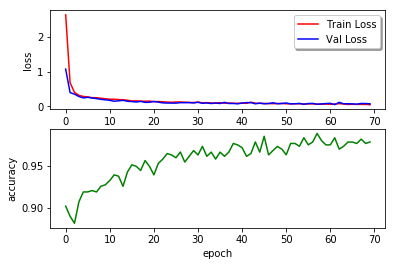

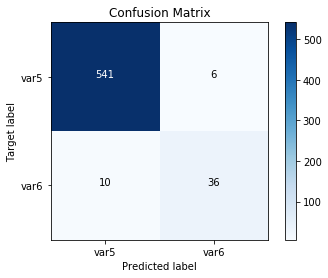

EPOCH: 71
TRAIN LOSS: 0.05471915005088074
VAL LOSS: 0.07595118296676502
VAL ACCURACY: 98.1 %
TIME: 15.6 s


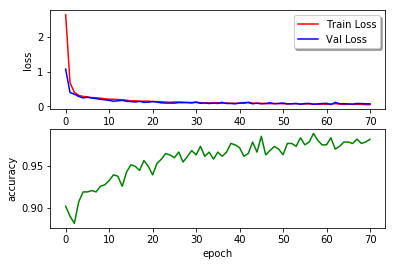

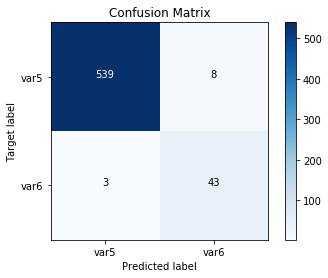

EPOCH: 72
TRAIN LOSS: 0.04844534711931492
VAL LOSS: 0.07416387472062758
VAL ACCURACY: 97.8 %
TIME: 16.4 s


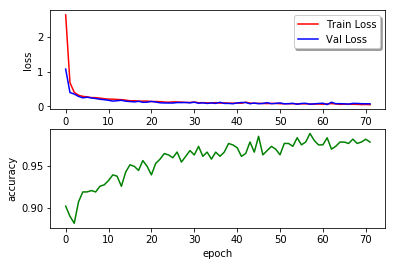

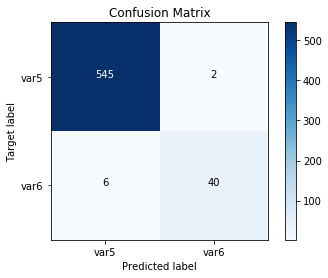

EPOCH: 73
TRAIN LOSS: 0.05669007054899355
VAL LOSS: 0.06362386560462915
VAL ACCURACY: 98.6 %
TIME: 14.8 s


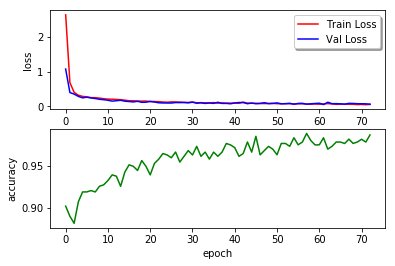

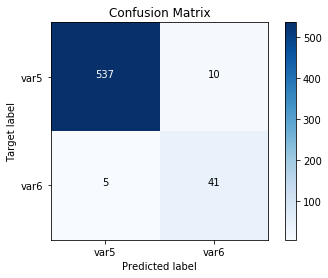

EPOCH: 74
TRAIN LOSS: 0.05689856646446861
VAL LOSS: 0.07463410676786501
VAL ACCURACY: 97.8 %
TIME: 15.2 s


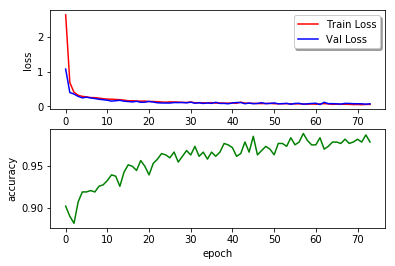

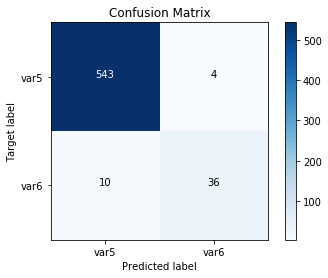

EPOCH: 75
TRAIN LOSS: 0.05130328023949916
VAL LOSS: 0.08903061326249388
VAL ACCURACY: 98.1 %
TIME: 14.8 s


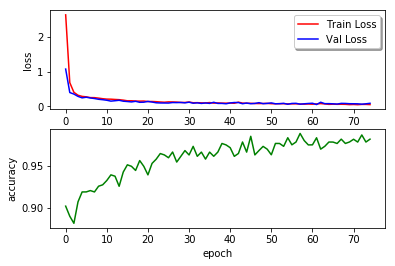

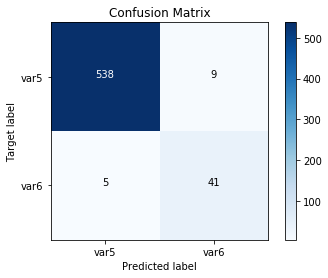

EPOCH: 76
TRAIN LOSS: 0.04818063460911938
VAL LOSS: 0.06917543815648265
VAL ACCURACY: 98.1 %
TIME: 14.6 s


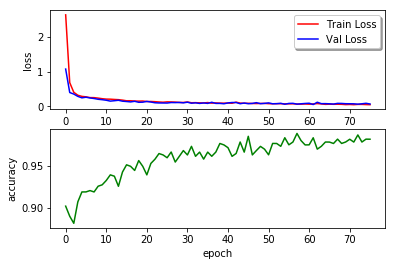

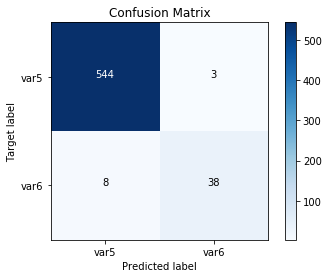

EPOCH: 77
TRAIN LOSS: 0.04754222201899504
VAL LOSS: 0.06994596393341024
VAL ACCURACY: 98.6 %
TIME: 14.7 s


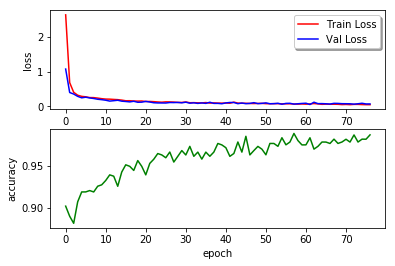

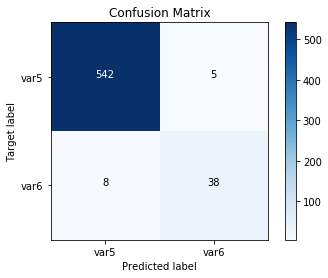

EPOCH: 78
TRAIN LOSS: 0.05395716143305856
VAL LOSS: 0.08508697384348282
VAL ACCURACY: 97.9 %
TIME: 15.1 s


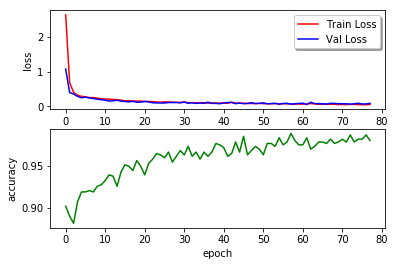

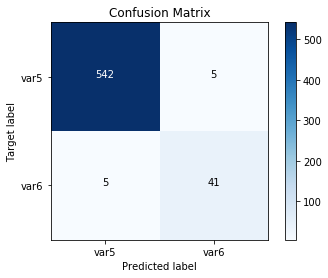

EPOCH: 79
TRAIN LOSS: 0.049635588412363915
VAL LOSS: 0.08466805065784914
VAL ACCURACY: 98.3 %
TIME: 15.2 s


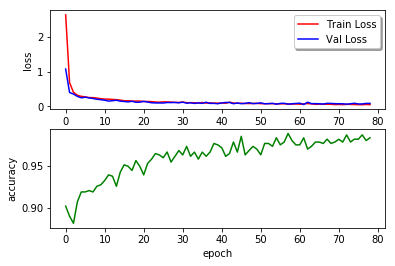

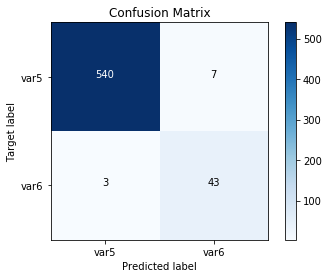

EPOCH: 80
TRAIN LOSS: 0.051310453516322935
VAL LOSS: 0.08313334483280965
VAL ACCURACY: 97.8 %
TIME: 14.9 s


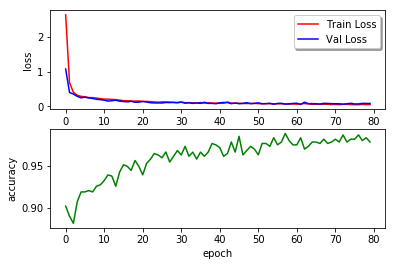

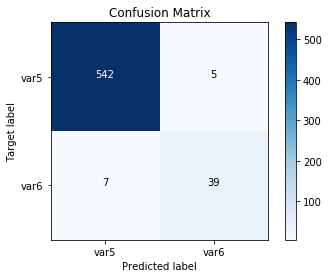

EPOCH: 81
TRAIN LOSS: 0.05006345661996691
VAL LOSS: 0.07657512841635997
VAL ACCURACY: 98.1 %
TIME: 14.7 s


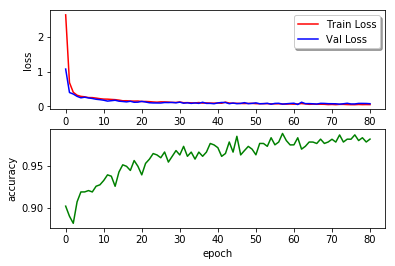

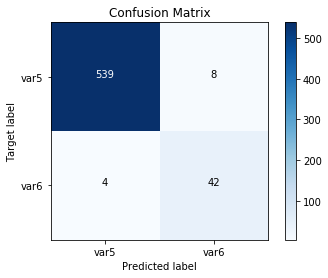

EPOCH: 82
TRAIN LOSS: 0.03977995666650551
VAL LOSS: 0.07303176638184739
VAL ACCURACY: 97.9 %
TIME: 14.7 s


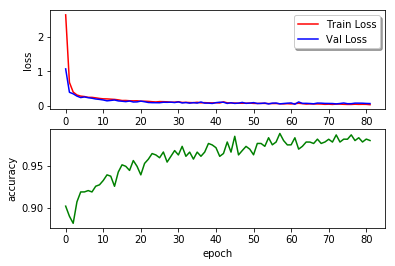

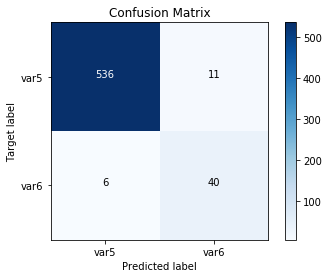

EPOCH: 83
TRAIN LOSS: 0.04344708794865982
VAL LOSS: 0.08586621981036827
VAL ACCURACY: 97.6 %
TIME: 15.1 s


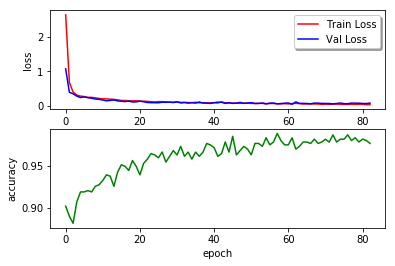

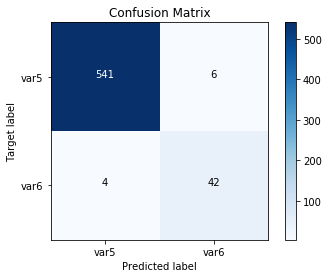

EPOCH: 84
TRAIN LOSS: 0.04087409424336867
VAL LOSS: 0.07050430355690261
VAL ACCURACY: 98.1 %
TIME: 18.2 s


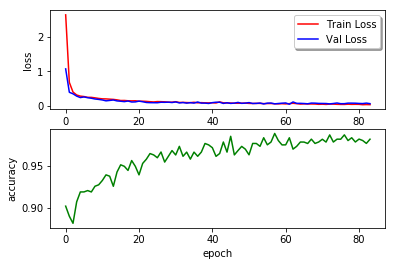

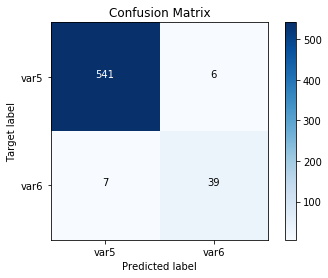

EPOCH: 85
TRAIN LOSS: 0.03990382351367775
VAL LOSS: 0.07196894055220922
VAL ACCURACY: 97.3 %
TIME: 15.8 s


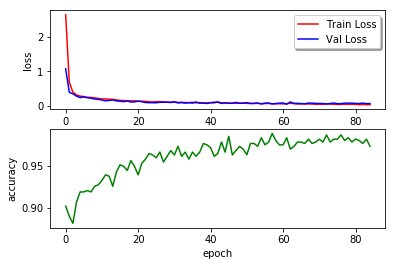

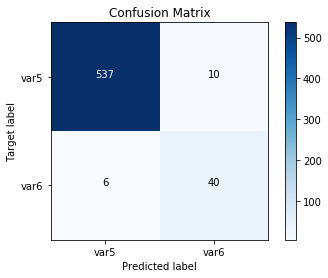

EPOCH: 86
TRAIN LOSS: 0.0450910776798112
VAL LOSS: 0.07238226121130079
VAL ACCURACY: 97.6 %
TIME: 17.0 s


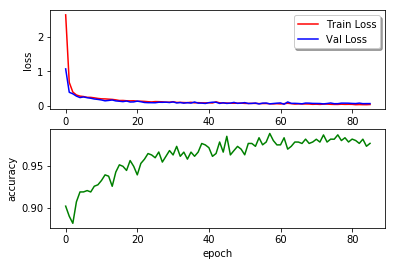

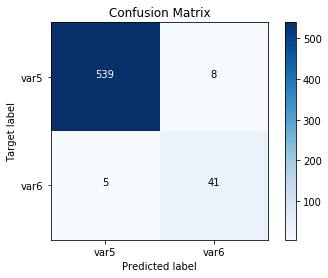

EPOCH: 87
TRAIN LOSS: 0.04305365144151042
VAL LOSS: 0.08301526175934565
VAL ACCURACY: 98.1 %
TIME: 14.9 s


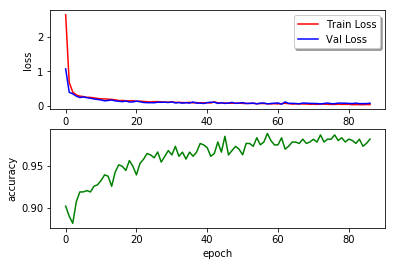

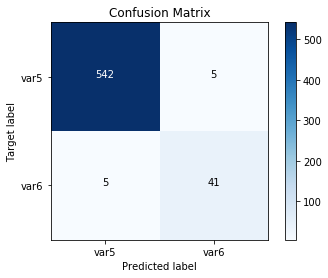

EPOCH: 88
TRAIN LOSS: 0.04122475044545171
VAL LOSS: 0.05508211021133502
VAL ACCURACY: 98.1 %
TIME: 17.7 s


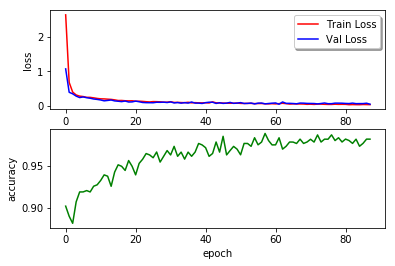

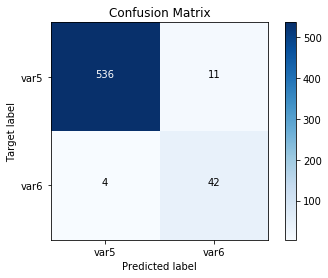

EPOCH: 89
TRAIN LOSS: 0.041512079523118556
VAL LOSS: 0.09132735315780302
VAL ACCURACY: 97.9 %
TIME: 16.5 s


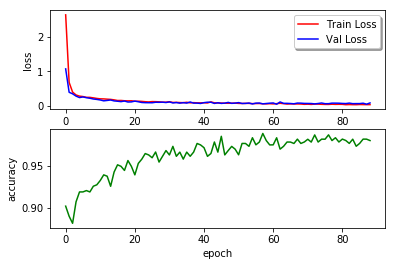

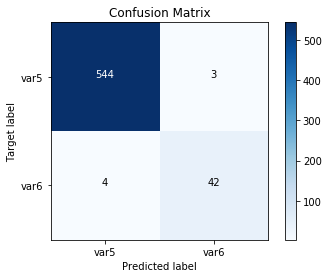

EPOCH: 90
TRAIN LOSS: 0.03449871311056392
VAL LOSS: 0.06145027077251695
VAL ACCURACY: 98.3 %
TIME: 16.1 s


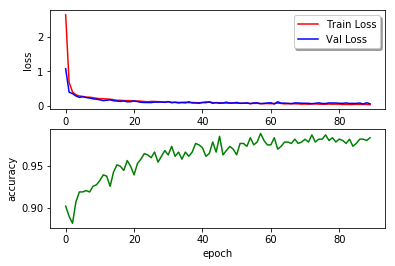

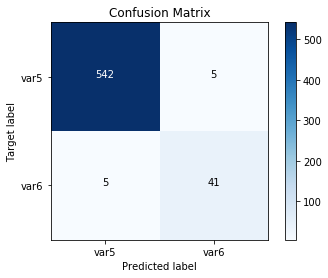

EPOCH: 91
TRAIN LOSS: 0.039120030902531855
VAL LOSS: 0.06780401282580042
VAL ACCURACY: 97.8 %
TIME: 15.4 s


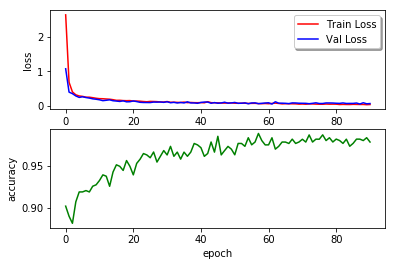

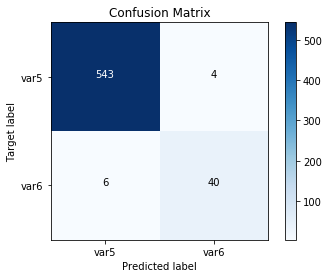

EPOCH: 92
TRAIN LOSS: 0.03869589744013156
VAL LOSS: 0.09711645893879209
VAL ACCURACY: 97.6 %
TIME: 15.4 s


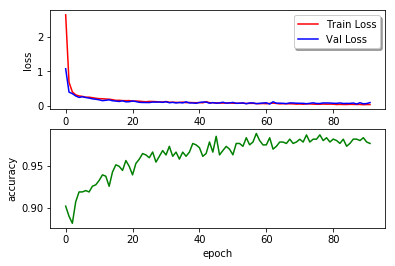

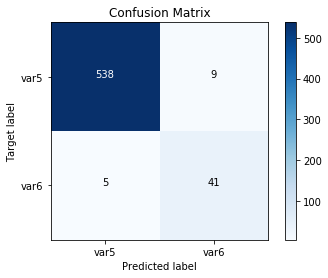

EPOCH: 93
TRAIN LOSS: 0.0426956912286605
VAL LOSS: 0.07337086538511618
VAL ACCURACY: 98.1 %
TIME: 15.3 s


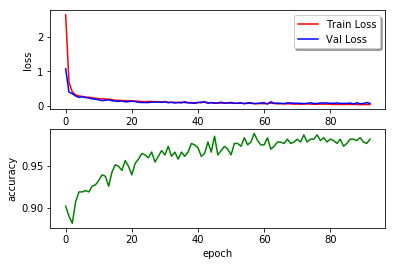

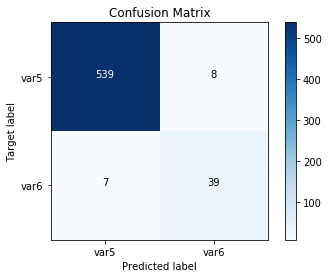

EPOCH: 94
TRAIN LOSS: 0.037329729412980336
VAL LOSS: 0.0801124145081899
VAL ACCURACY: 98.1 %
TIME: 15.4 s


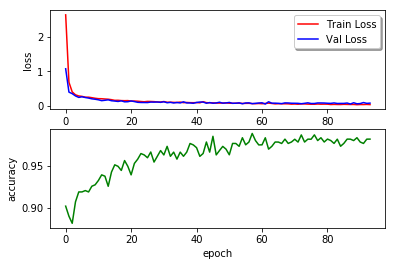

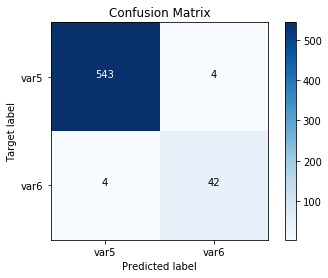

EPOCH: 95
TRAIN LOSS: 0.03374286707533056
VAL LOSS: 0.08092908264165441
VAL ACCURACY: 97.8 %
TIME: 15.0 s


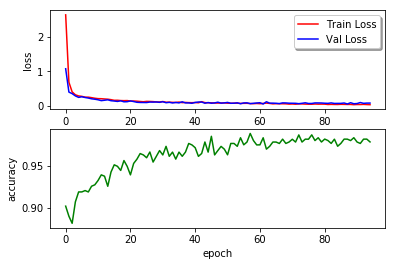

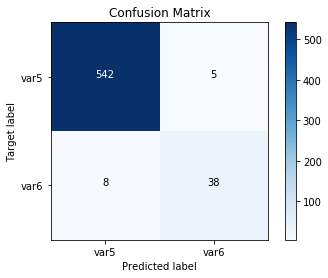

EPOCH: 96
TRAIN LOSS: 0.033041174280337246
VAL LOSS: 0.06636162859205692
VAL ACCURACY: 98.4 %
TIME: 14.8 s


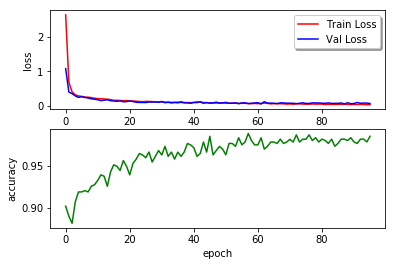

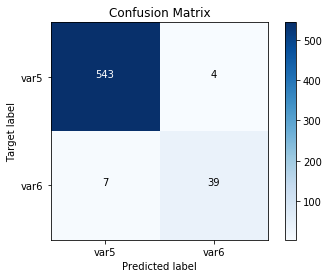

EPOCH: 97
TRAIN LOSS: 0.03784560475742797
VAL LOSS: 0.0841602335701354
VAL ACCURACY: 97.6 %
TIME: 14.7 s


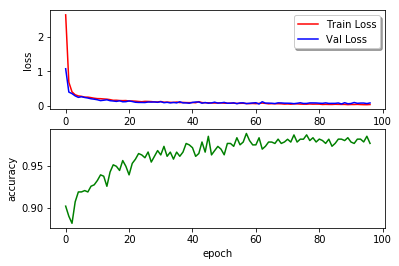

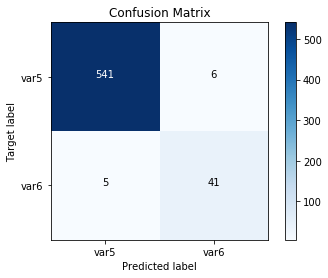

EPOCH: 98
TRAIN LOSS: 0.03690595449909352
VAL LOSS: 0.08959042690689979
VAL ACCURACY: 97.6 %
TIME: 14.8 s


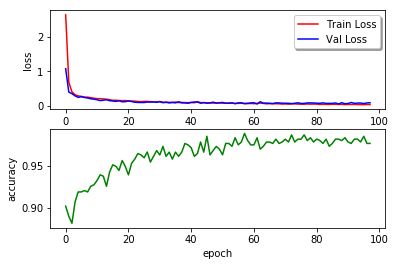

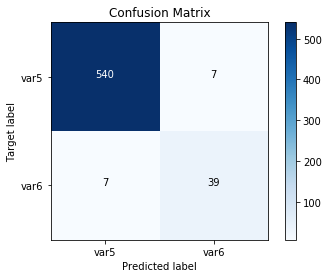

EPOCH: 99
TRAIN LOSS: 0.0380054177913723
VAL LOSS: 0.07397389270960666
VAL ACCURACY: 97.8 %
TIME: 15.8 s


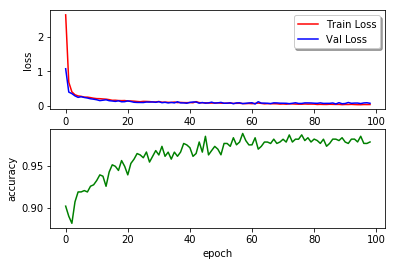

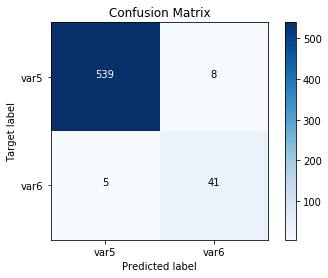

EPOCH: 100
TRAIN LOSS: 0.03264528085978263
VAL LOSS: 0.07846632971677453
VAL ACCURACY: 97.8 %
TIME: 16.9 s


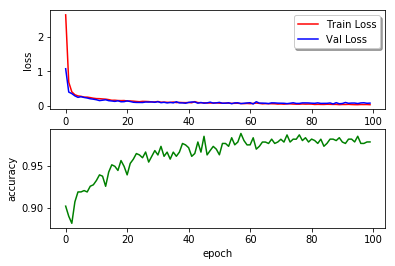

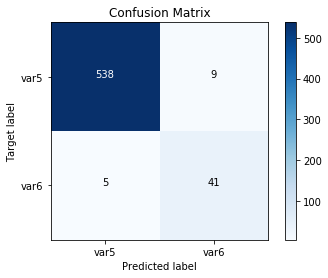

EPOCH: 101
TRAIN LOSS: 0.03298350190012894
VAL LOSS: 0.07773392729206316
VAL ACCURACY: 98.3 %
TIME: 16.4 s


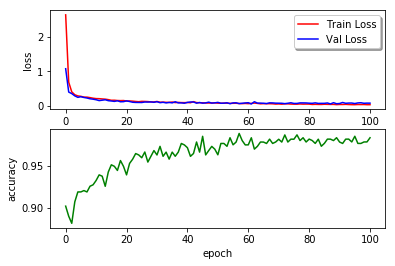

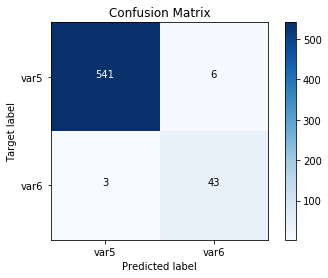

EPOCH: 102
TRAIN LOSS: 0.0442072660874076
VAL LOSS: 0.07487039850024427
VAL ACCURACY: 98.3 %
TIME: 15.3 s


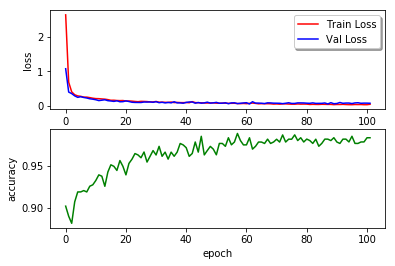

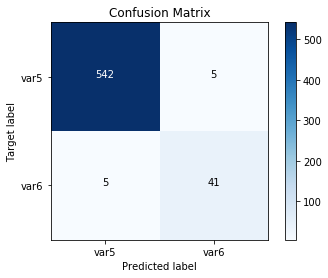

EPOCH: 103
TRAIN LOSS: 0.035133453188522075
VAL LOSS: 0.06406114107362561
VAL ACCURACY: 98.4 %
TIME: 15.2 s


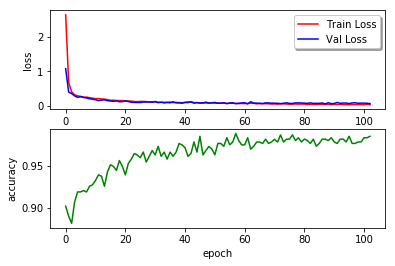

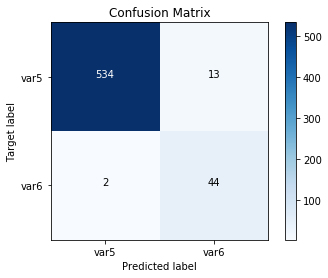

EPOCH: 104
TRAIN LOSS: 0.03389555587242947
VAL LOSS: 0.0834596577923492
VAL ACCURACY: 98.3 %
TIME: 14.8 s


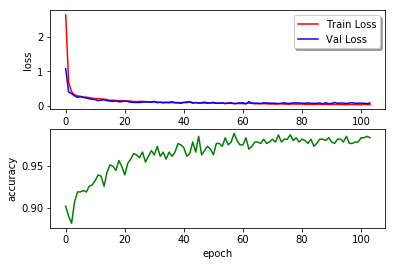

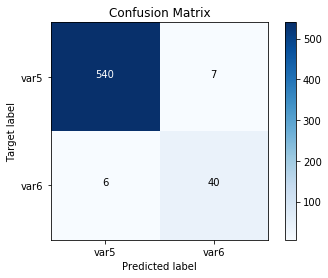

EPOCH: 105
TRAIN LOSS: 0.03377483810856616
VAL LOSS: 0.07890868903160635
VAL ACCURACY: 97.6 %
TIME: 16.9 s


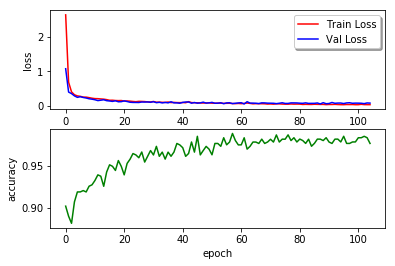

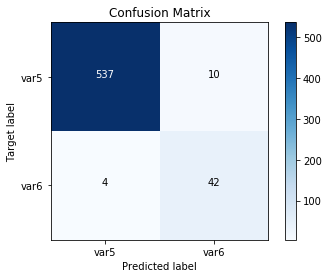

EPOCH: 106
TRAIN LOSS: 0.031975750377180756
VAL LOSS: 0.0822011859737062
VAL ACCURACY: 98.3 %
TIME: 15.7 s


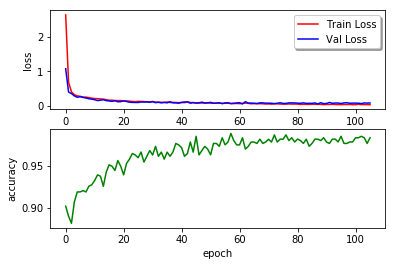

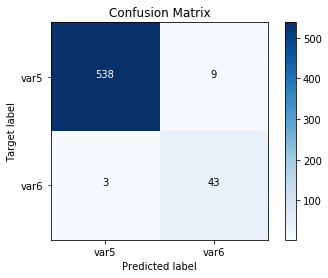

EPOCH: 107
TRAIN LOSS: 0.029771272014236173
VAL LOSS: 0.06327343528830837
VAL ACCURACY: 98.3 %
TIME: 14.8 s


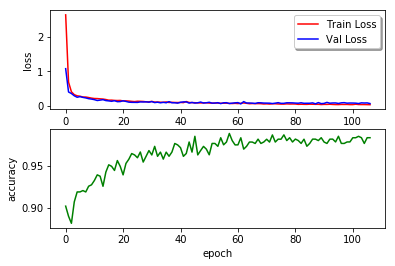

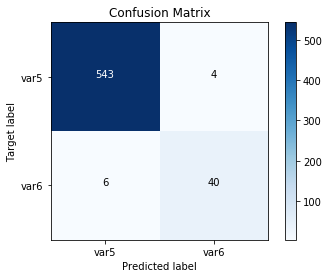

EPOCH: 108
TRAIN LOSS: 0.028802935057012792
VAL LOSS: 0.07802761562275773
VAL ACCURACY: 98.8 %
TIME: 14.9 s


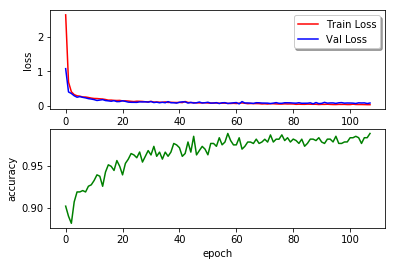

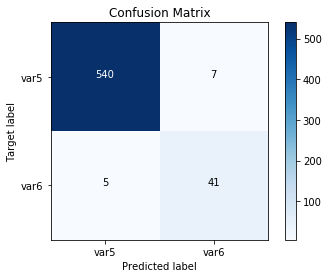

EPOCH: 109
TRAIN LOSS: 0.02804326135825374
VAL LOSS: 0.08550817053357623
VAL ACCURACY: 98.3 %
TIME: 16.0 s


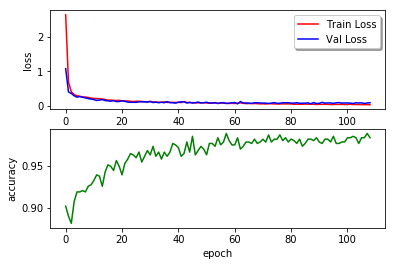

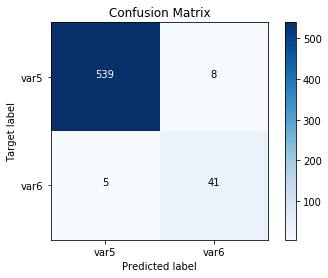

EPOCH: 110
TRAIN LOSS: 0.028520496669547687
VAL LOSS: 0.08130496144091928
VAL ACCURACY: 97.9 %
TIME: 15.6 s


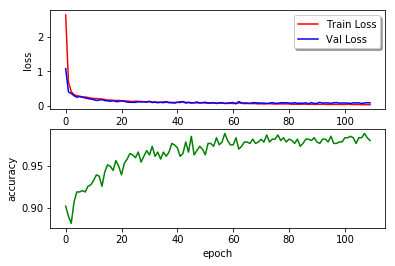

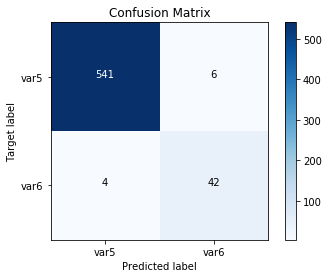

EPOCH: 111
TRAIN LOSS: 0.023965693406707646
VAL LOSS: 0.0879376901930422
VAL ACCURACY: 97.3 %
TIME: 15.1 s


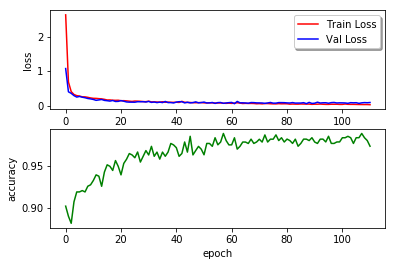

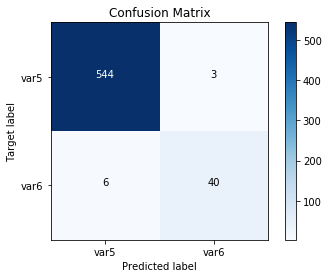

EPOCH: 112
TRAIN LOSS: 0.026606211030068376
VAL LOSS: 0.09221804010731413
VAL ACCURACY: 97.9 %
TIME: 14.9 s


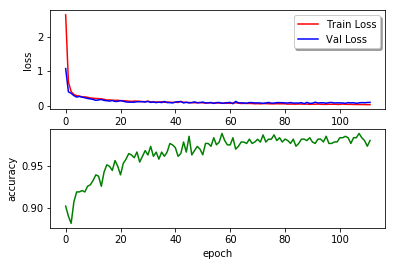

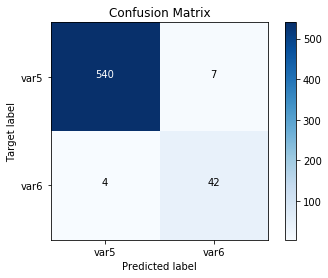

EPOCH: 113
TRAIN LOSS: 0.02638602051645505
VAL LOSS: 0.09257266751005316
VAL ACCURACY: 97.8 %
TIME: 15.3 s


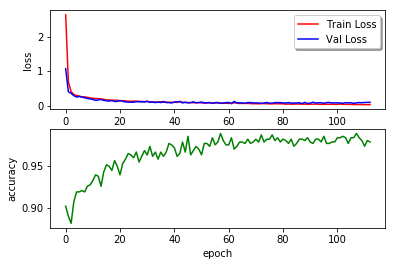

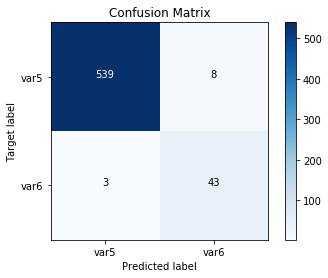

EPOCH: 114
TRAIN LOSS: 0.028120786769346845
VAL LOSS: 0.08649122877370417
VAL ACCURACY: 97.8 %
TIME: 15.2 s


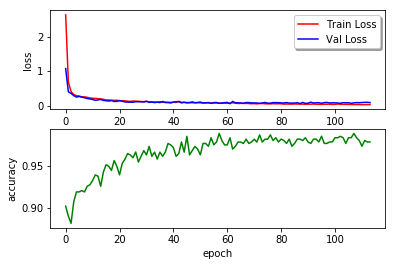

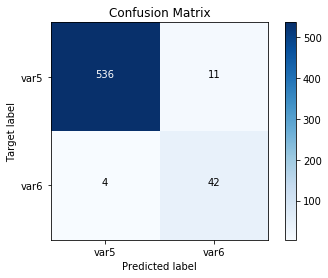

EPOCH: 115
TRAIN LOSS: 0.026491045401349368
VAL LOSS: 0.08686027492881804
VAL ACCURACY: 98.9 %
TIME: 15.8 s


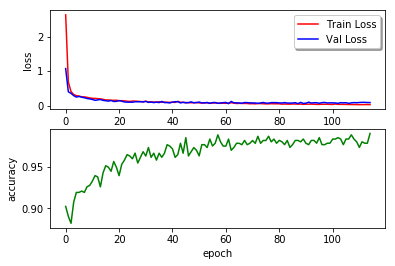

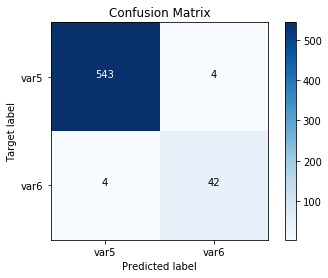

EPOCH: 116
TRAIN LOSS: 0.022138463932480985
VAL LOSS: 0.07951564087481355
VAL ACCURACY: 98.1 %
TIME: 14.7 s


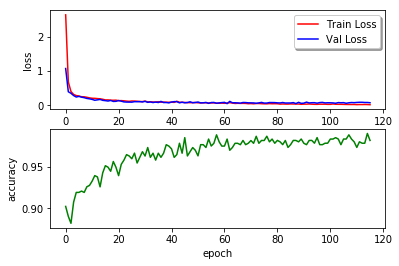

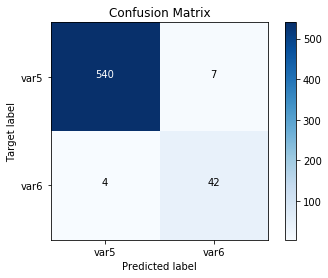

EPOCH: 117
TRAIN LOSS: 0.023953710344493607
VAL LOSS: 0.0905967566165016
VAL ACCURACY: 98.1 %
TIME: 19.0 s


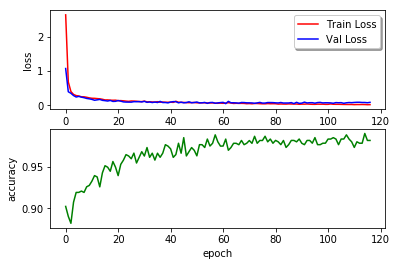

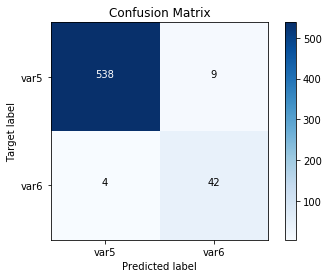

EPOCH: 118
TRAIN LOSS: 0.022432502600317258
VAL LOSS: 0.08344204658821631
VAL ACCURACY: 98.3 %
TIME: 19.4 s


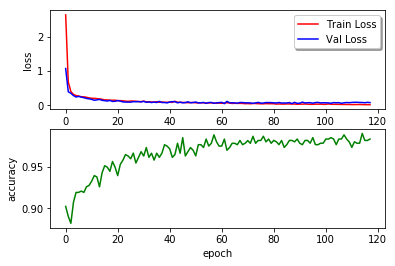

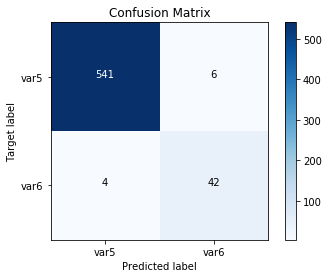

EPOCH: 119
TRAIN LOSS: 0.020717536570039465
VAL LOSS: 0.06552261798905713
VAL ACCURACY: 98.4 %
TIME: 19.3 s


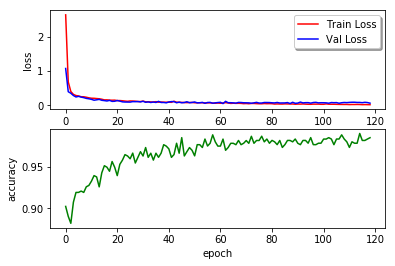

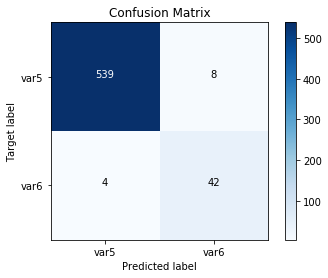

EPOCH: 120
TRAIN LOSS: 0.022787800942170255
VAL LOSS: 0.07677457643567286
VAL ACCURACY: 98.6 %
TIME: 15.8 s


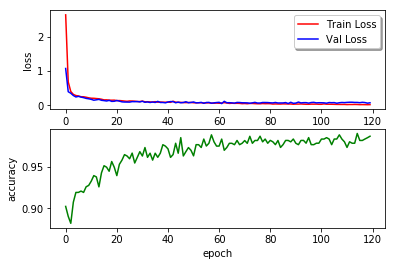

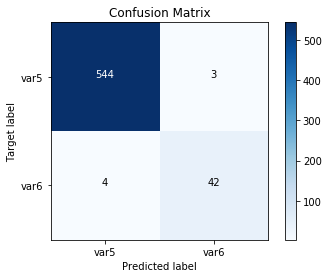

EPOCH: 121
TRAIN LOSS: 0.024745761838973764
VAL LOSS: 0.06605451697905516
VAL ACCURACY: 98.8 %
TIME: 14.7 s


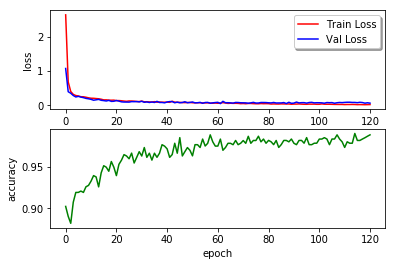

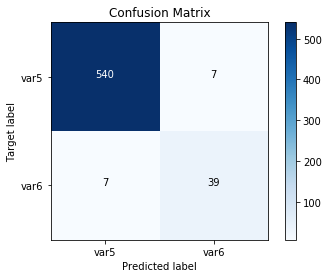

EPOCH: 122
TRAIN LOSS: 0.024169399288213527
VAL LOSS: 0.06416371721864975
VAL ACCURACY: 98.8 %
TIME: 14.6 s


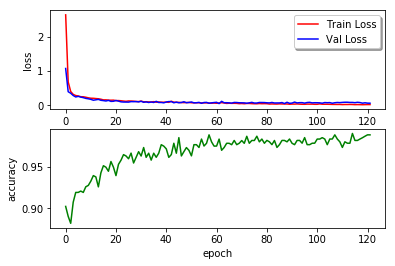

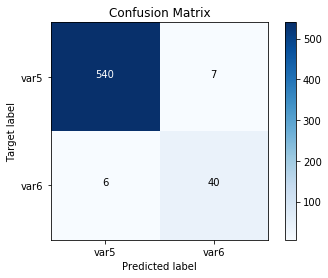

EPOCH: 123
TRAIN LOSS: 0.023006498005105746
VAL LOSS: 0.0509113516754809
VAL ACCURACY: 97.9 %
TIME: 15.0 s


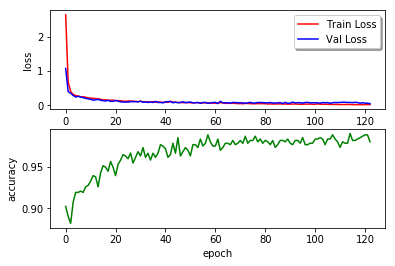

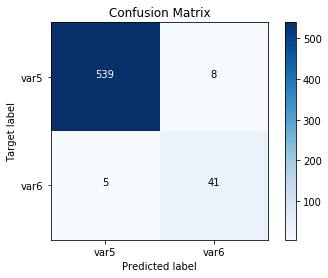

EPOCH: 124
TRAIN LOSS: 0.024940230962771853
VAL LOSS: 0.0822079560465386
VAL ACCURACY: 98.4 %
TIME: 17.5 s


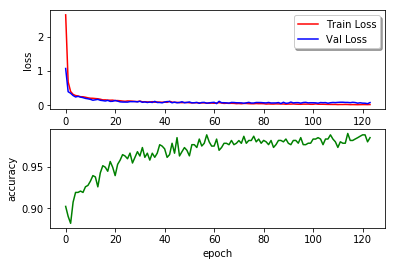

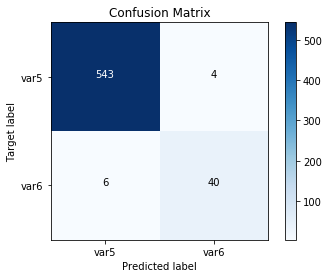

EPOCH: 125
TRAIN LOSS: 0.02893666479802748
VAL LOSS: 0.11354468440158204
VAL ACCURACY: 97.9 %
TIME: 19.8 s


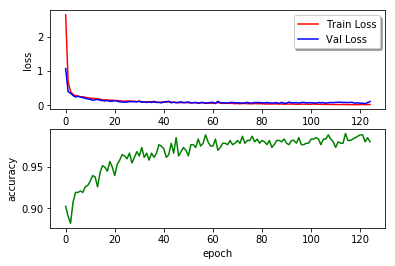

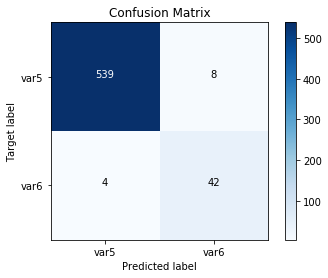

EPOCH: 126
TRAIN LOSS: 0.024165512953050132
VAL LOSS: 0.09912322293641204
VAL ACCURACY: 98.4 %
TIME: 22.9 s


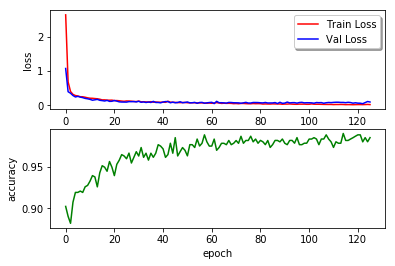

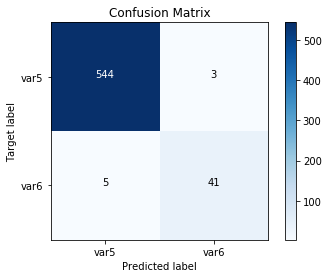

EPOCH: 127
TRAIN LOSS: 0.025179350128288154
VAL LOSS: 0.08913979913167425
VAL ACCURACY: 98.1 %
TIME: 15.8 s


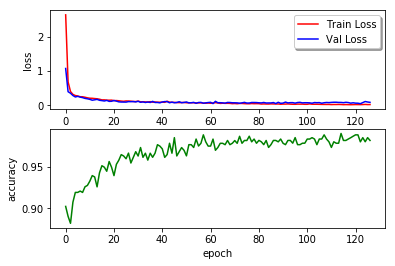

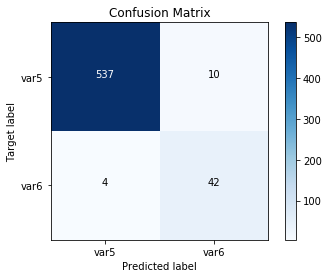

EPOCH: 128
TRAIN LOSS: 0.01881388158914858
VAL LOSS: 0.0822883336751051
VAL ACCURACY: 98.4 %
TIME: 14.6 s


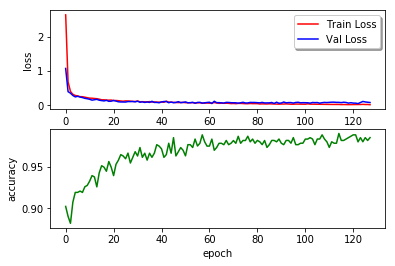

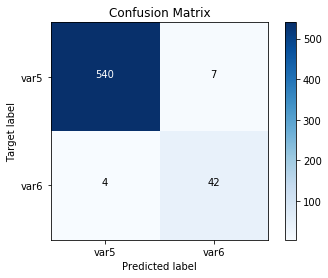

EPOCH: 129
TRAIN LOSS: 0.017013454185599807
VAL LOSS: 0.07074354352417335
VAL ACCURACY: 98.3 %
TIME: 15.1 s


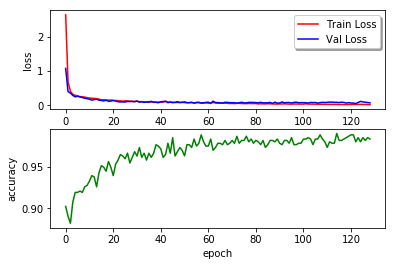

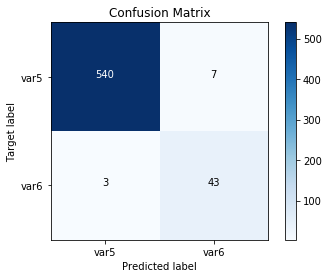

EPOCH: 130
TRAIN LOSS: 0.018491431115965698
VAL LOSS: 0.09998126531398333
VAL ACCURACY: 97.3 %
TIME: 15.3 s


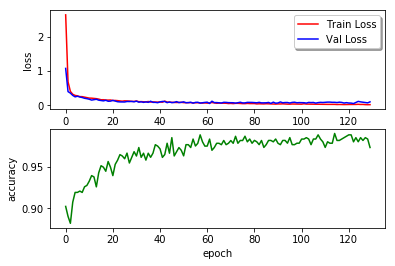

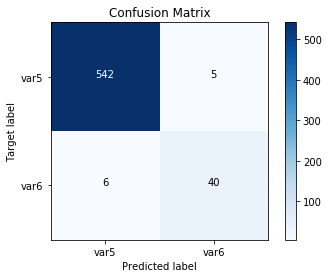

EPOCH: 131
TRAIN LOSS: 0.02367815886564322
VAL LOSS: 0.08750183276573692
VAL ACCURACY: 98.1 %
TIME: 14.6 s


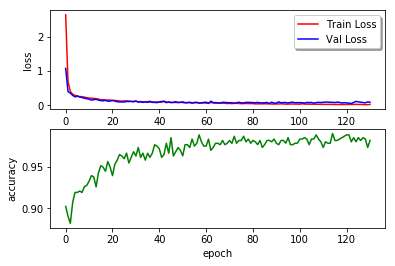

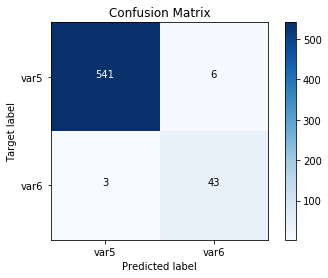

EPOCH: 132
TRAIN LOSS: 0.02502163696702691
VAL LOSS: 0.07336640386215215
VAL ACCURACY: 98.8 %
TIME: 14.8 s


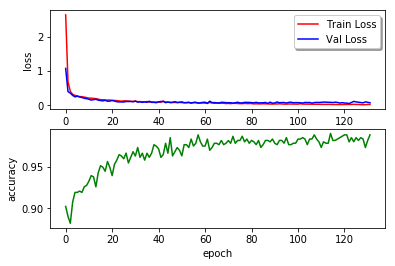

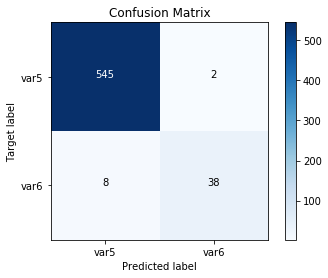

EPOCH: 133
TRAIN LOSS: 0.020406930764537534
VAL LOSS: 0.07908304184760834
VAL ACCURACY: 98.8 %
TIME: 14.6 s


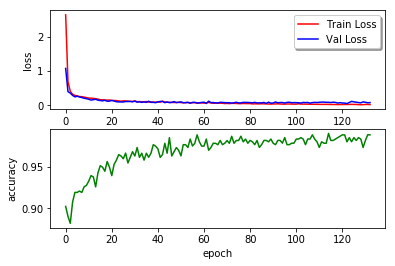

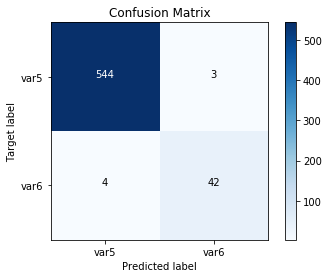

EPOCH: 134
TRAIN LOSS: 0.02113588380341775
VAL LOSS: 0.07495918498869406
VAL ACCURACY: 98.3 %
TIME: 15.0 s


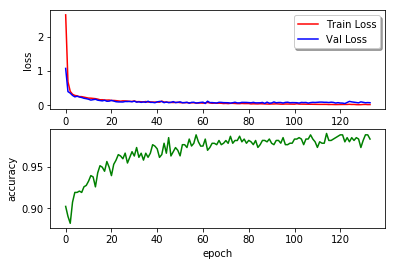

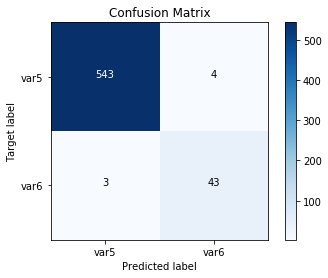

EPOCH: 135
TRAIN LOSS: 0.01986138886474571
VAL LOSS: 0.11289889052201527
VAL ACCURACY: 98.1 %
TIME: 14.7 s


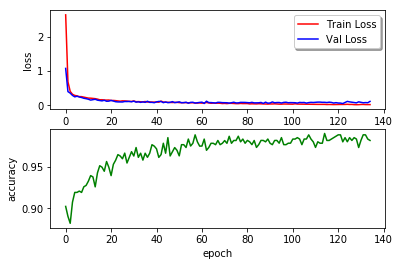

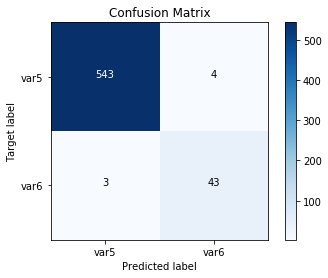

EPOCH: 136
TRAIN LOSS: 0.022141781465298778
VAL LOSS: 0.12828728766865724
VAL ACCURACY: 96.1 %
TIME: 14.7 s


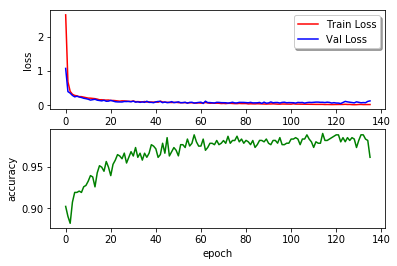

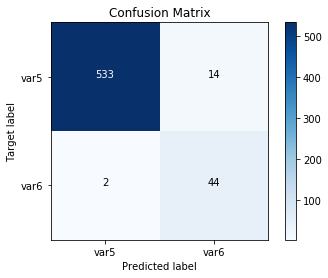

EPOCH: 137
TRAIN LOSS: 0.026309044630910494
VAL LOSS: 0.09062587420588886
VAL ACCURACY: 98.3 %
TIME: 14.6 s


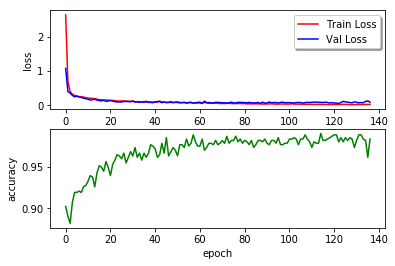

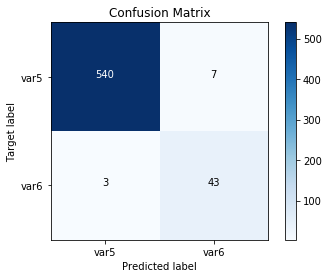

EPOCH: 138
TRAIN LOSS: 0.020712502598157136
VAL LOSS: 0.10404933147584394
VAL ACCURACY: 98.6 %
TIME: 14.6 s


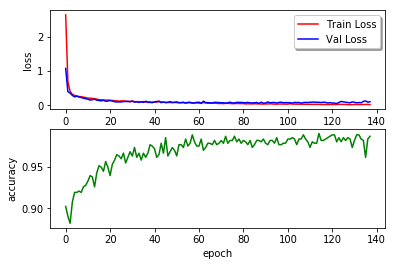

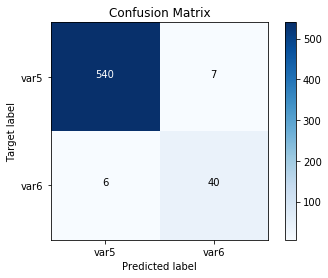

EPOCH: 139
TRAIN LOSS: 0.016381326172452897
VAL LOSS: 0.08201157298070179
VAL ACCURACY: 98.8 %
TIME: 14.6 s


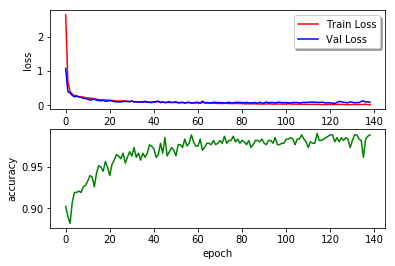

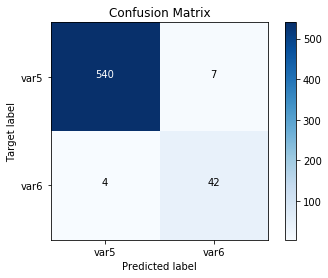

EPOCH: 140
TRAIN LOSS: 0.02094906773588213
VAL LOSS: 0.07219234603907708
VAL ACCURACY: 98.4 %
TIME: 14.6 s


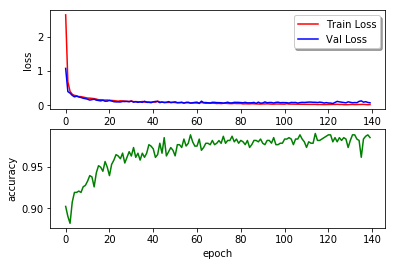

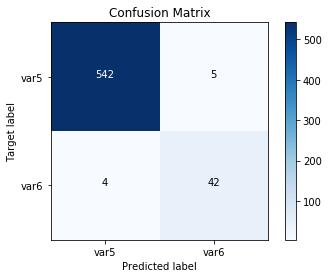

EPOCH: 141
TRAIN LOSS: 0.013574403430187926
VAL LOSS: 0.09530192663802566
VAL ACCURACY: 98.3 %
TIME: 14.9 s


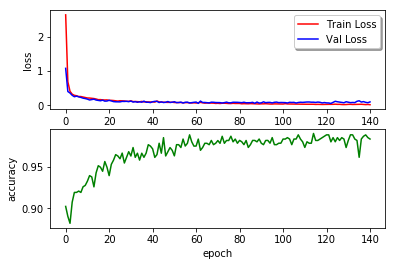

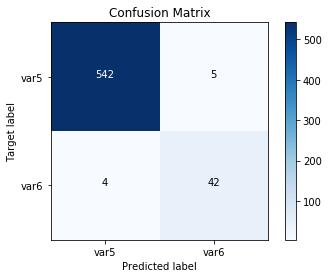

EPOCH: 142
TRAIN LOSS: 0.023994003359425684
VAL LOSS: 0.09827075531358836
VAL ACCURACY: 98.3 %
TIME: 14.9 s


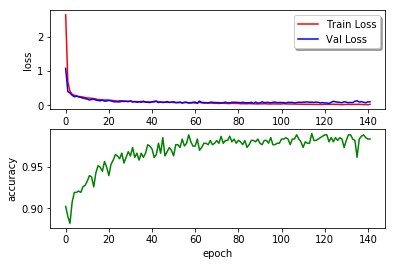

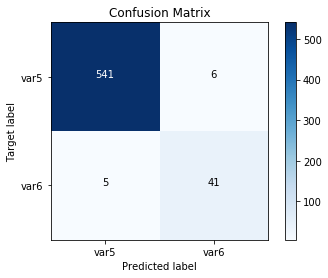

EPOCH: 143
TRAIN LOSS: 0.016664651778846573
VAL LOSS: 0.0746164050093508
VAL ACCURACY: 98.3 %
TIME: 15.3 s


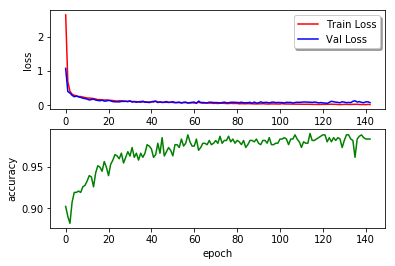

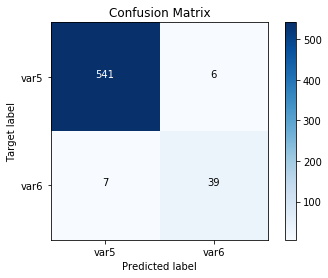

EPOCH: 144
TRAIN LOSS: 0.022543308302846284
VAL LOSS: 0.09767324345577211
VAL ACCURACY: 97.6 %
TIME: 15.3 s


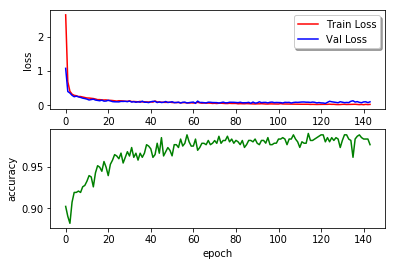

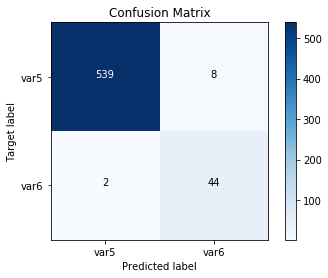

EPOCH: 145
TRAIN LOSS: 0.02303630708071168
VAL LOSS: 0.08488061840402185
VAL ACCURACY: 98.3 %
TIME: 14.7 s


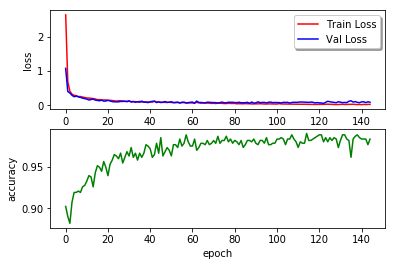

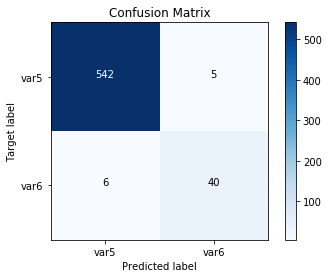

EPOCH: 146
TRAIN LOSS: 0.018639270752191815
VAL LOSS: 0.10565974699497102
VAL ACCURACY: 98.6 %
TIME: 14.5 s


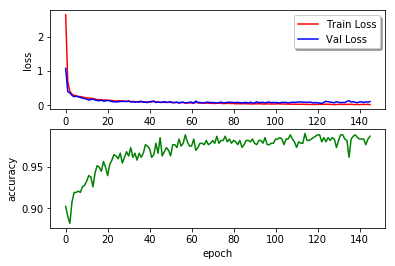

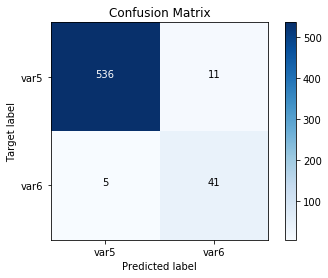

EPOCH: 147
TRAIN LOSS: 0.017939691934395083
VAL LOSS: 0.082606188138901
VAL ACCURACY: 98.4 %
TIME: 14.5 s


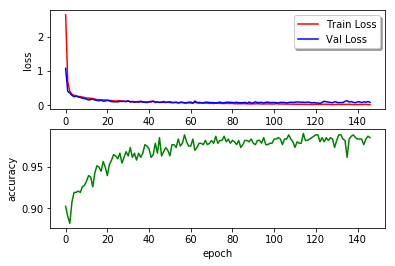

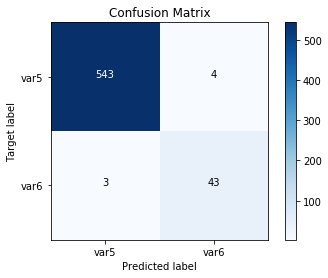

EPOCH: 148
TRAIN LOSS: 0.017163152451627542
VAL LOSS: 0.06397276990676135
VAL ACCURACY: 98.4 %
TIME: 14.6 s


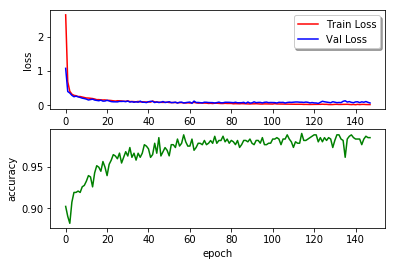

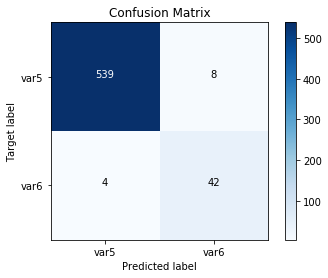

EPOCH: 149
TRAIN LOSS: 0.01643798856583269
VAL LOSS: 0.0999585172578728
VAL ACCURACY: 98.3 %
TIME: 14.8 s


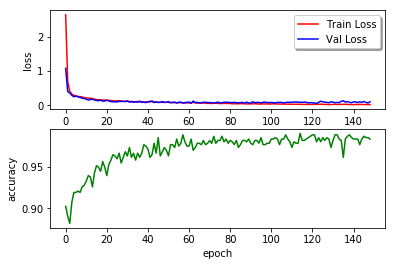

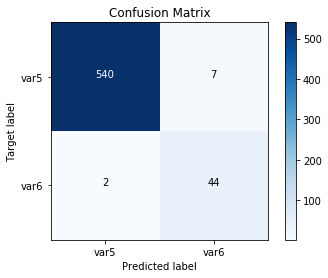

EPOCH: 150
TRAIN LOSS: 0.014329829962725
VAL LOSS: 0.10174199711652071
VAL ACCURACY: 98.3 %
TIME: 14.6 s


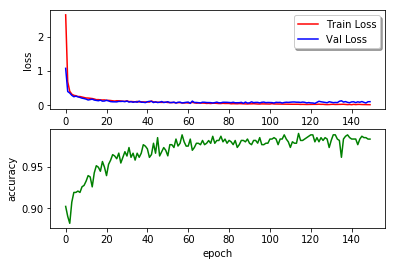

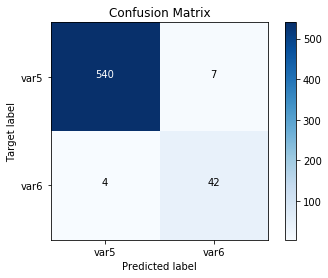

EPOCH: 151
TRAIN LOSS: 0.015608848808146954
VAL LOSS: 0.08788139345549695
VAL ACCURACY: 98.6 %
TIME: 14.6 s


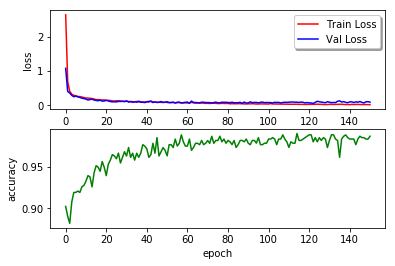

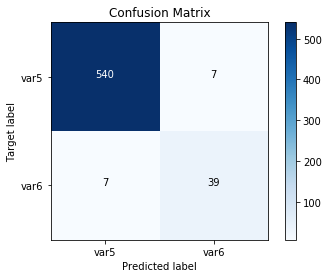

EPOCH: 152
TRAIN LOSS: 0.016504172248353842
VAL LOSS: 0.09893557731856452
VAL ACCURACY: 97.6 %
TIME: 14.6 s


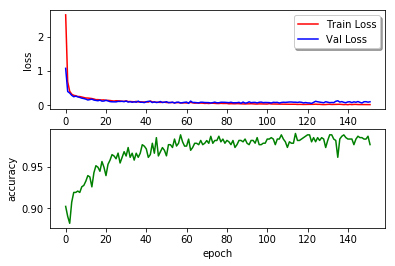

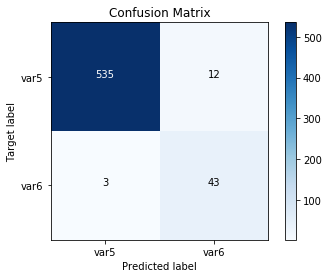

EPOCH: 153
TRAIN LOSS: 0.01817670035174585
VAL LOSS: 0.05298645325929104
VAL ACCURACY: 98.9 %
TIME: 14.7 s


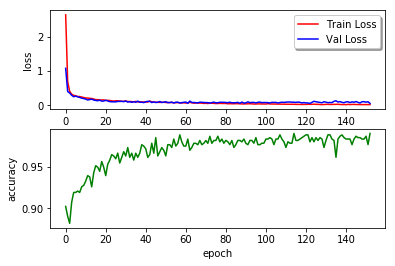

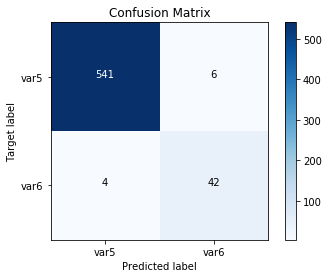

EPOCH: 154
TRAIN LOSS: 0.0187203842962788
VAL LOSS: 0.09234187543510192
VAL ACCURACY: 98.8 %
TIME: 14.7 s


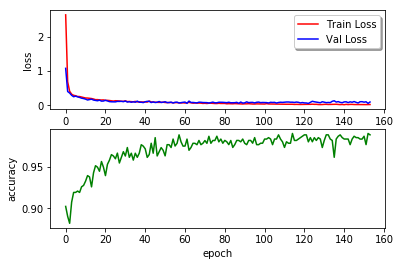

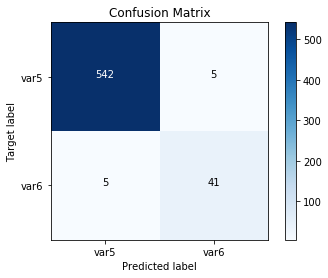

EPOCH: 155
TRAIN LOSS: 0.013295741692845116
VAL LOSS: 0.09119500774596798
VAL ACCURACY: 98.4 %
TIME: 14.6 s


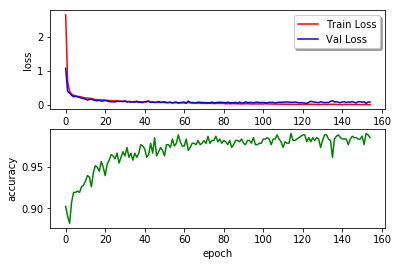

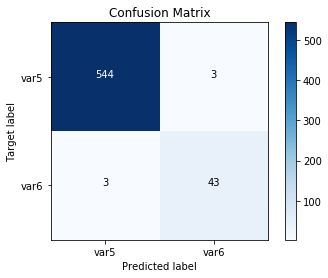

EPOCH: 156
TRAIN LOSS: 0.012231122762915008
VAL LOSS: 0.08234364132855959
VAL ACCURACY: 98.8 %
TIME: 14.9 s


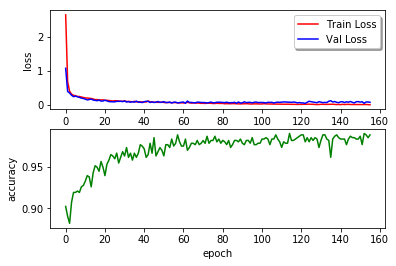

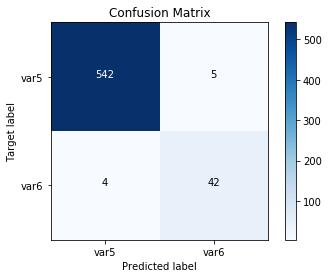

EPOCH: 157
TRAIN LOSS: 0.011860221899395427
VAL LOSS: 0.11742347727198527
VAL ACCURACY: 98.4 %
TIME: 14.7 s


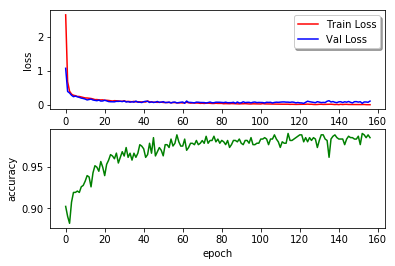

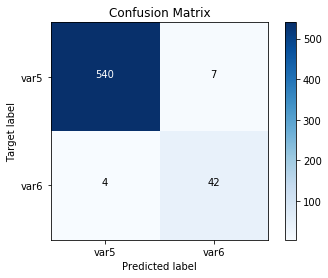

EPOCH: 158
TRAIN LOSS: 0.012688016688089901
VAL LOSS: 0.09011671428296908
VAL ACCURACY: 98.3 %
TIME: 15.1 s


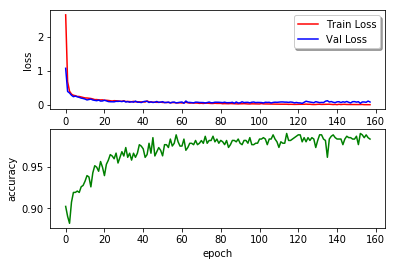

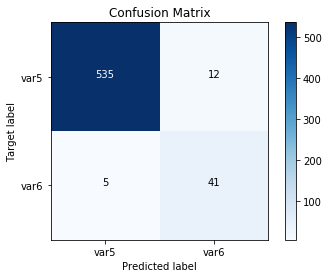

EPOCH: 159
TRAIN LOSS: 0.011565290352292042
VAL LOSS: 0.13275448746159274
VAL ACCURACY: 97.4 %
TIME: 14.6 s


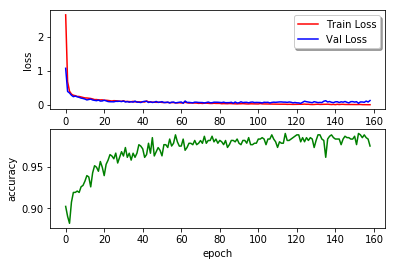

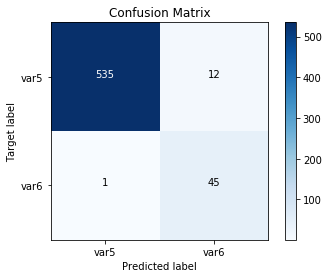

EPOCH: 160
TRAIN LOSS: 0.016006130331600345
VAL LOSS: 0.06769109125984894
VAL ACCURACY: 98.3 %
TIME: 14.6 s


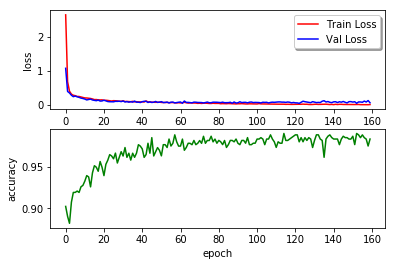

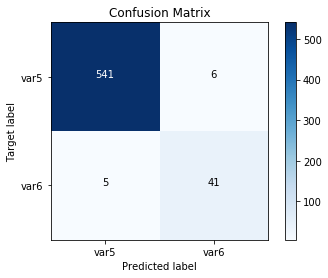

EPOCH: 161
TRAIN LOSS: 0.013997896756855864
VAL LOSS: 0.08641710004051512
VAL ACCURACY: 98.1 %
TIME: 14.9 s


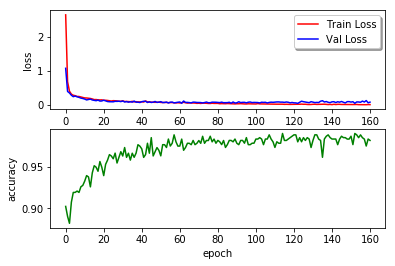

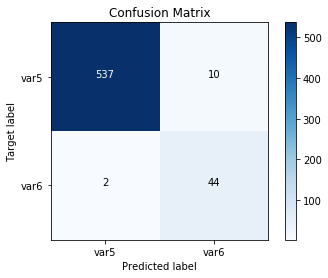

EPOCH: 162
TRAIN LOSS: 0.011620998992990602
VAL LOSS: 0.11835395606680513
VAL ACCURACY: 98.1 %
TIME: 14.9 s


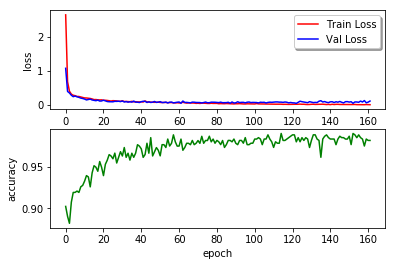

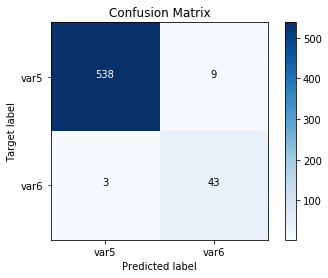

EPOCH: 163
TRAIN LOSS: 0.015344467878022931
VAL LOSS: 0.07078665107433703
VAL ACCURACY: 98.6 %
TIME: 15.4 s


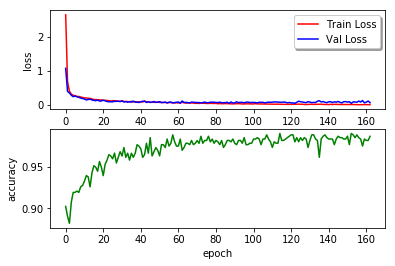

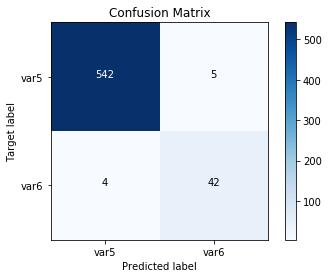

EPOCH: 164
TRAIN LOSS: 0.014161735478041983
VAL LOSS: 0.10234413858632825
VAL ACCURACY: 98.1 %
TIME: 16.3 s


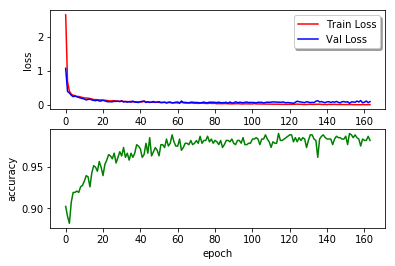

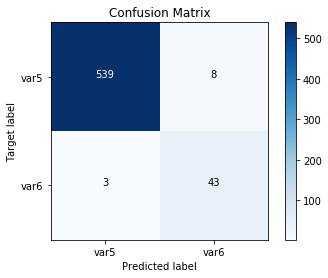

EPOCH: 165
TRAIN LOSS: 0.015721936751415297
VAL LOSS: 0.08337888895634088
VAL ACCURACY: 98.6 %
TIME: 15.1 s


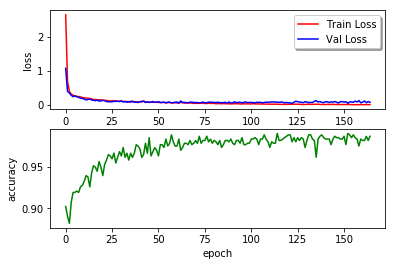

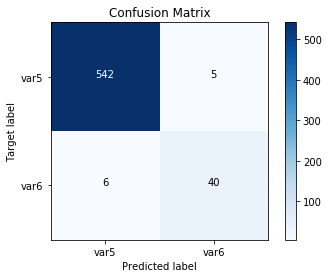

EPOCH: 166
TRAIN LOSS: 0.010812738705962964
VAL LOSS: 0.11569196599359977
VAL ACCURACY: 97.8 %
TIME: 14.7 s


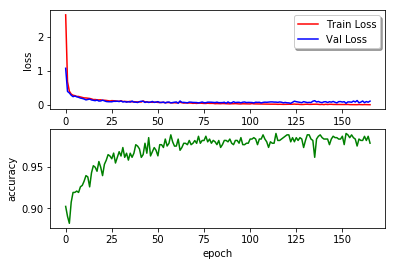

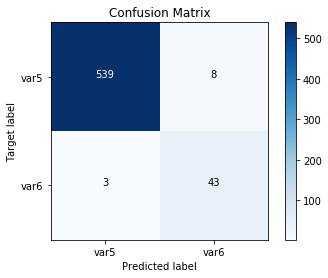

EPOCH: 167
TRAIN LOSS: 0.012600132587496333
VAL LOSS: 0.11670912400935804
VAL ACCURACY: 97.3 %
TIME: 14.7 s


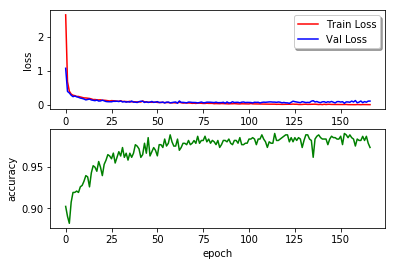

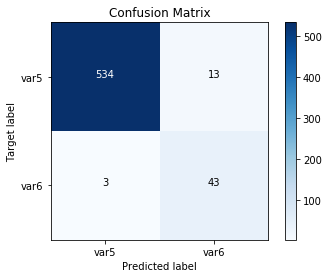

EPOCH: 168
TRAIN LOSS: 0.01350042634466405
VAL LOSS: 0.10102199966645053
VAL ACCURACY: 98.1 %
TIME: 14.7 s


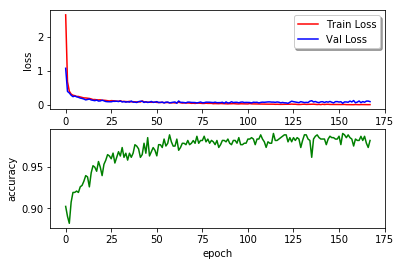

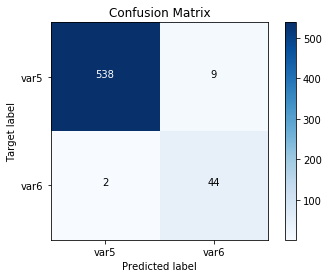

EPOCH: 169
TRAIN LOSS: 0.013109075414740663
VAL LOSS: 0.11393363675344731
VAL ACCURACY: 97.6 %
TIME: 14.7 s


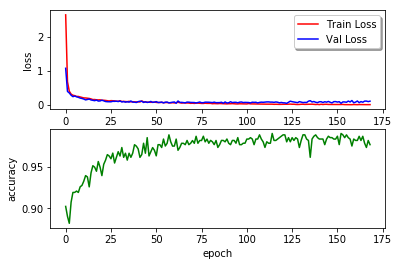

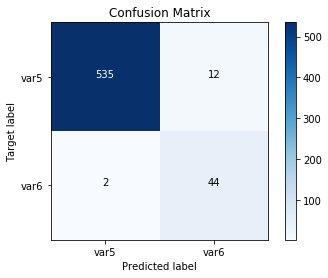

EPOCH: 170
TRAIN LOSS: 0.016051111283231598
VAL LOSS: 0.1514167721444276
VAL ACCURACY: 96.9 %
TIME: 14.8 s


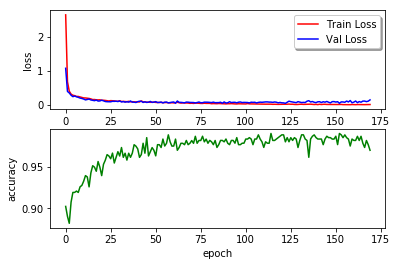

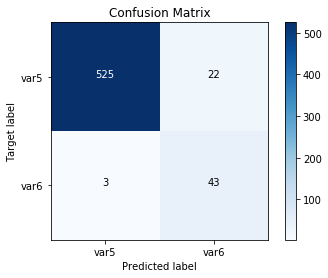

EPOCH: 171
TRAIN LOSS: 0.014776942920759442
VAL LOSS: 0.10214068789108244
VAL ACCURACY: 97.1 %
TIME: 15.3 s


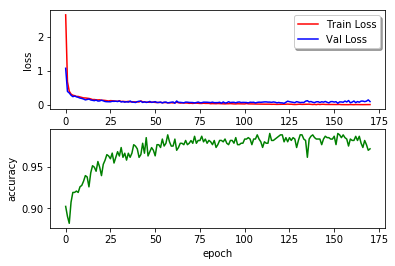

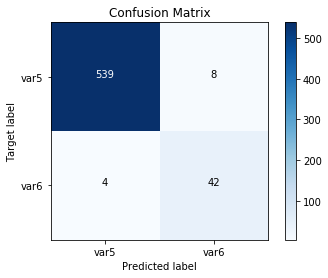

EPOCH: 172
TRAIN LOSS: 0.012080689262530094
VAL LOSS: 0.10967988257976698
VAL ACCURACY: 97.9 %
TIME: 15.4 s


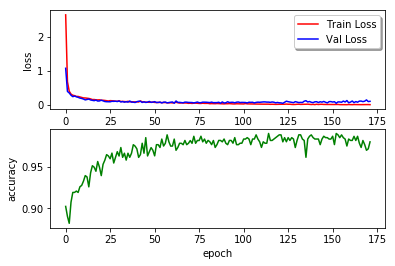

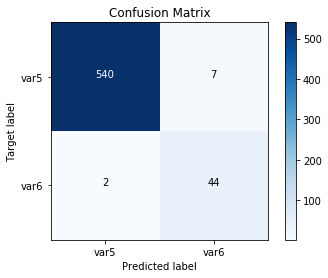

EPOCH: 173
TRAIN LOSS: 0.01563195364302902
VAL LOSS: 0.08766449464247075
VAL ACCURACY: 98.3 %
TIME: 15.1 s


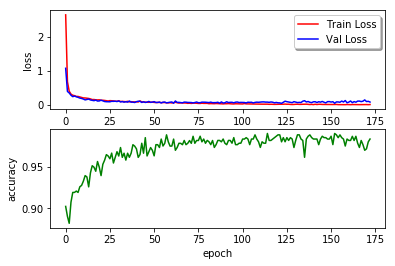

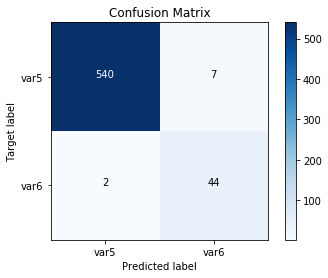

EPOCH: 174
TRAIN LOSS: 0.012570392474936866
VAL LOSS: 0.14412109867923828
VAL ACCURACY: 97.4 %
TIME: 15.2 s


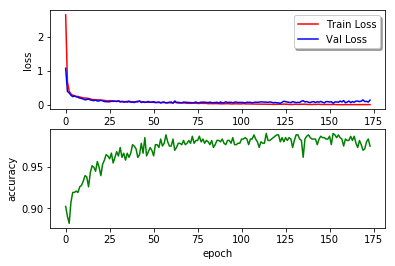

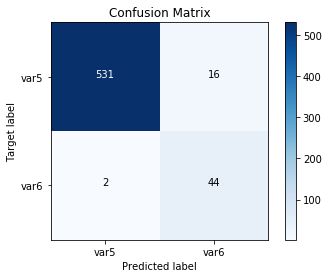

EPOCH: 175
TRAIN LOSS: 0.017450494427461875
VAL LOSS: 0.08206189621433048
VAL ACCURACY: 97.9 %
TIME: 15.0 s


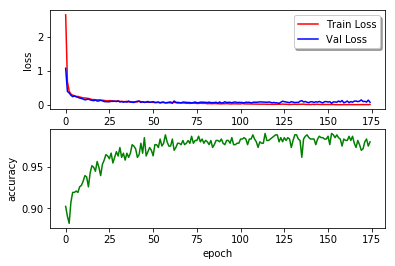

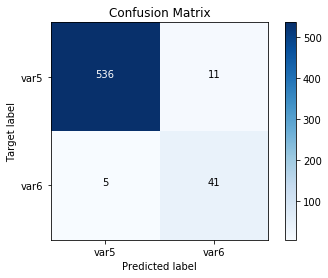

EPOCH: 176
TRAIN LOSS: 0.01745090212064312
VAL LOSS: 0.09069146771563814
VAL ACCURACY: 98.3 %
TIME: 15.1 s


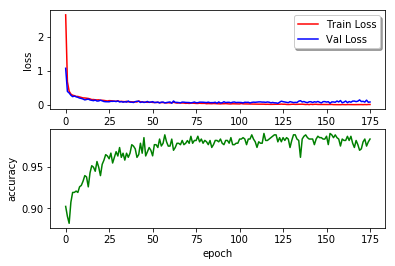

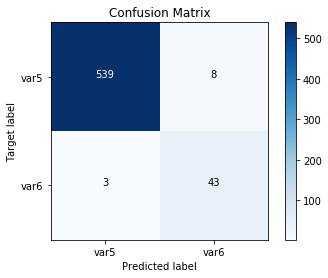

EPOCH: 177
TRAIN LOSS: 0.014212751584611244
VAL LOSS: 0.10425876432792214
VAL ACCURACY: 97.6 %
TIME: 14.9 s


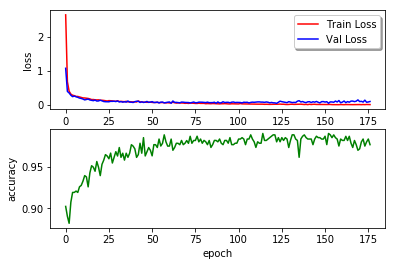

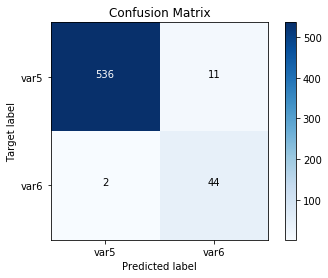

EPOCH: 178
TRAIN LOSS: 0.012580287629107038
VAL LOSS: 0.12468011047296686
VAL ACCURACY: 97.8 %
TIME: 16.0 s


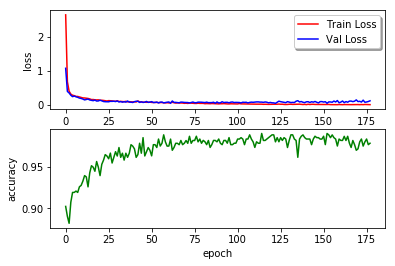

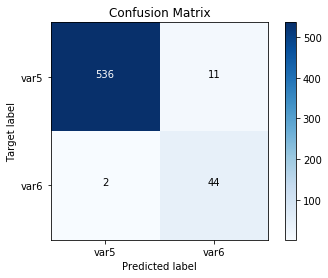

EPOCH: 179
TRAIN LOSS: 0.015197330348876374
VAL LOSS: 0.11562517939907171
VAL ACCURACY: 97.4 %
TIME: 14.9 s


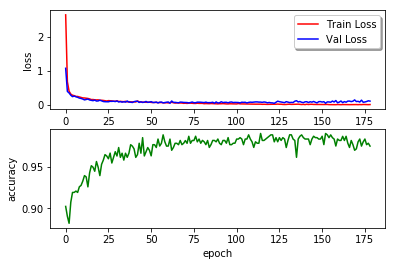

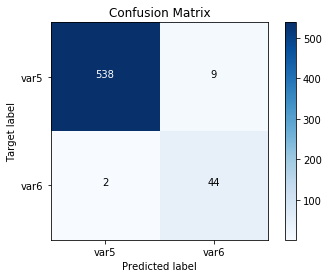

EPOCH: 180
TRAIN LOSS: 0.016400860585250344
VAL LOSS: 0.1375440151144485
VAL ACCURACY: 96.7 %
TIME: 14.8 s


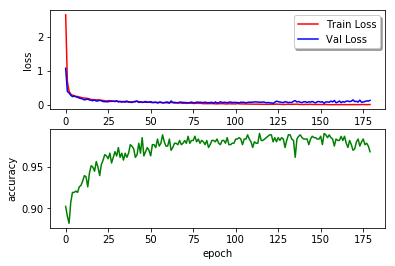

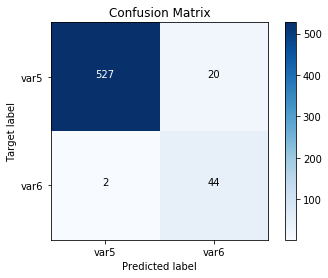

EPOCH: 181
TRAIN LOSS: 0.019902592375087493
VAL LOSS: 0.12419489916333068
VAL ACCURACY: 97.4 %
TIME: 15.7 s


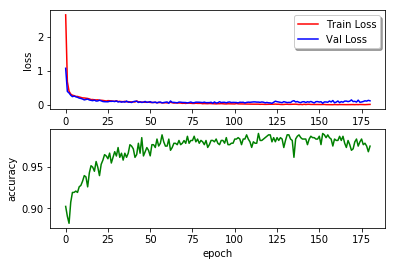

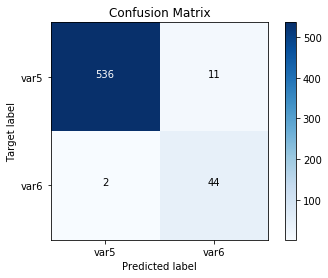

EPOCH: 182
TRAIN LOSS: 0.013009081406022673
VAL LOSS: 0.10322173961442031
VAL ACCURACY: 96.6 %
TIME: 15.3 s


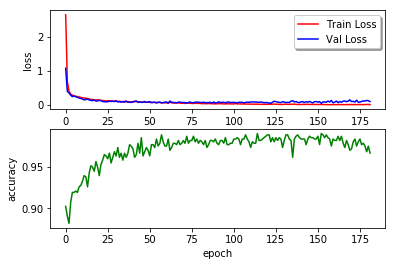

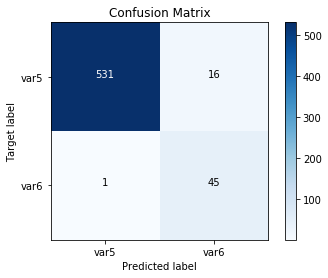

EPOCH: 183
TRAIN LOSS: 0.015716298681009266
VAL LOSS: 0.10428515423897528
VAL ACCURACY: 97.1 %
TIME: 15.0 s


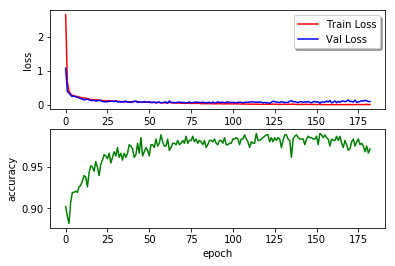

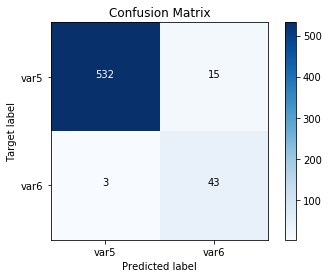

EPOCH: 184
TRAIN LOSS: 0.0156765188168137
VAL LOSS: 0.15367644306630476
VAL ACCURACY: 97.4 %
TIME: 15.1 s


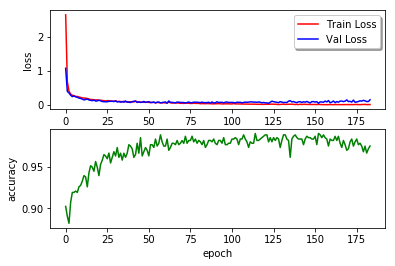

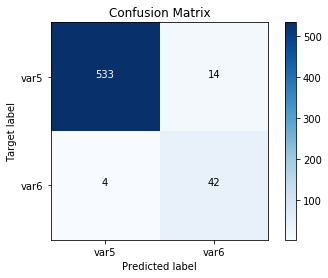

EPOCH: 185
TRAIN LOSS: 0.018466127987237933
VAL LOSS: 0.1567189631605117
VAL ACCURACY: 96.9 %
TIME: 15.2 s


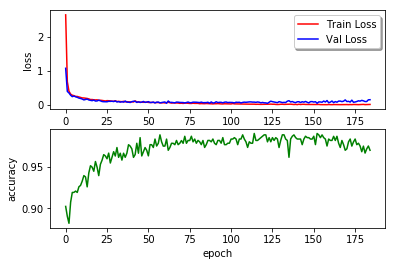

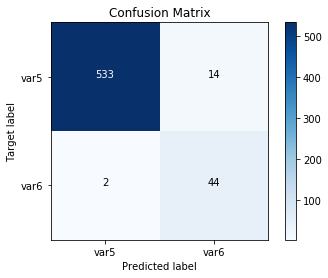

EPOCH: 186
TRAIN LOSS: 0.01617798267554592
VAL LOSS: 0.14345104257166827
VAL ACCURACY: 96.8 %
TIME: 15.4 s


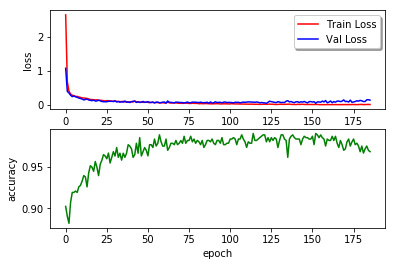

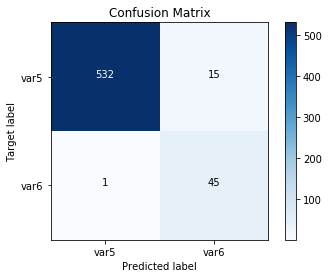

EPOCH: 187
TRAIN LOSS: 0.016282165145142538
VAL LOSS: 0.10603273113392556
VAL ACCURACY: 98.4 %
TIME: 15.0 s


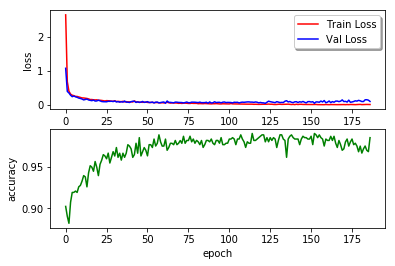

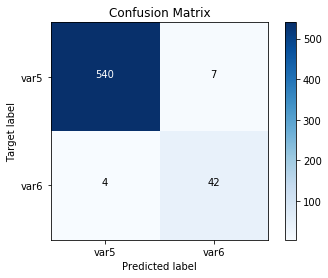

EPOCH: 188
TRAIN LOSS: 0.015513627995704628
VAL LOSS: 0.09732104770909572
VAL ACCURACY: 97.8 %
TIME: 15.2 s


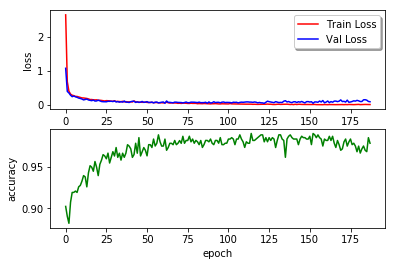

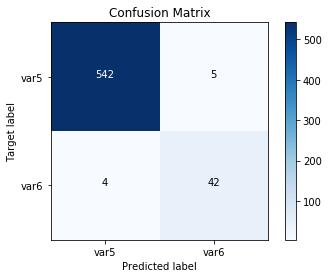

EPOCH: 189
TRAIN LOSS: 0.01958261799056027
VAL LOSS: 0.10077397426174262
VAL ACCURACY: 98.6 %
TIME: 15.1 s


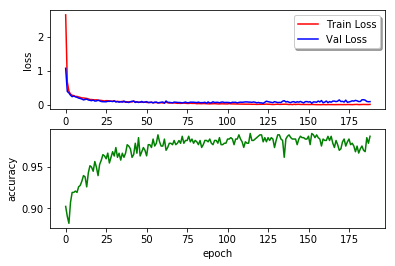

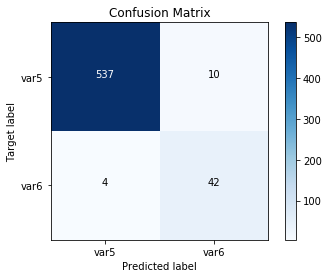

EPOCH: 190
TRAIN LOSS: 0.018066226109627697
VAL LOSS: 0.12881209481063274
VAL ACCURACY: 97.9 %
TIME: 15.0 s


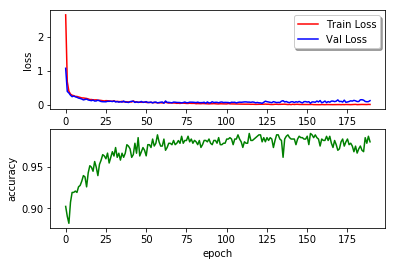

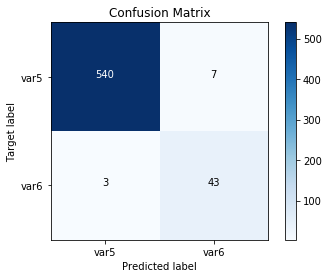

EPOCH: 191
TRAIN LOSS: 0.014773747034649816
VAL LOSS: 0.11889242437026562
VAL ACCURACY: 98.1 %
TIME: 15.2 s


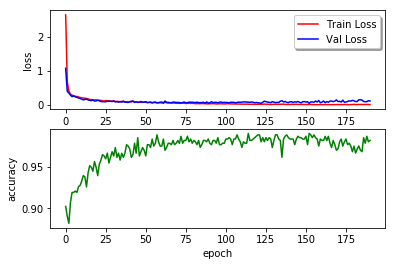

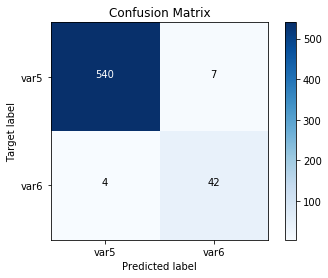

EPOCH: 192
TRAIN LOSS: 0.011949910345073988
VAL LOSS: 0.09131340840886007
VAL ACCURACY: 98.1 %
TIME: 14.8 s


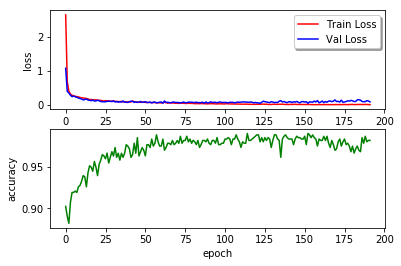

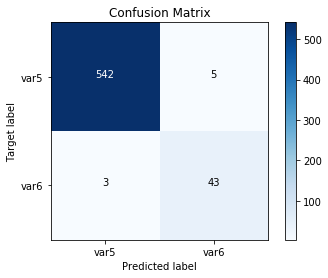

EPOCH: 193
TRAIN LOSS: 0.01531712349450438
VAL LOSS: 0.11375524476449272
VAL ACCURACY: 98.6 %
TIME: 16.4 s


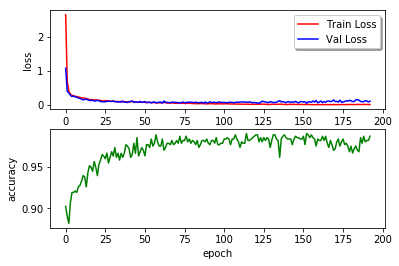

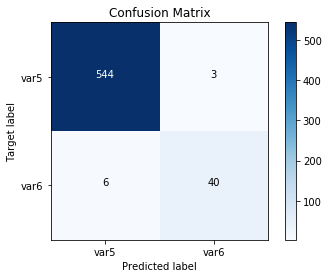

EPOCH: 194
TRAIN LOSS: 0.014109027236846046
VAL LOSS: 0.1068265816687532
VAL ACCURACY: 98.4 %
TIME: 15.5 s


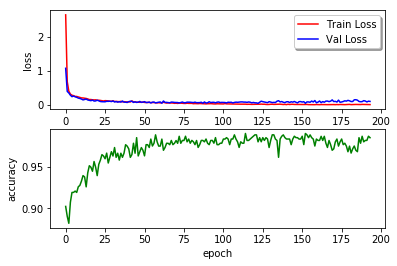

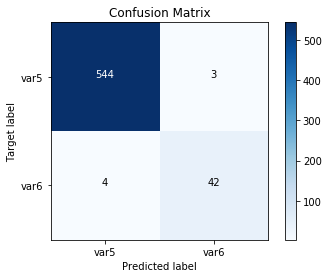

EPOCH: 195
TRAIN LOSS: 0.014709297887008848
VAL LOSS: 0.11969866849079103
VAL ACCURACY: 98.8 %
TIME: 17.8 s


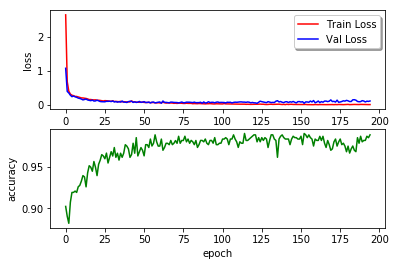

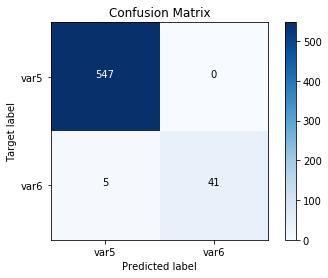

EPOCH: 196
TRAIN LOSS: 0.018904408852851048
VAL LOSS: 0.11931898864947502
VAL ACCURACY: 98.8 %
TIME: 17.1 s


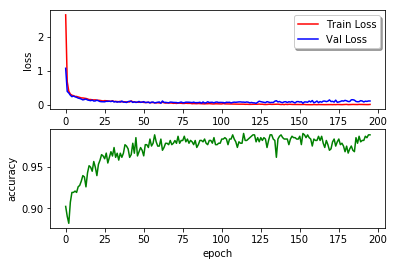

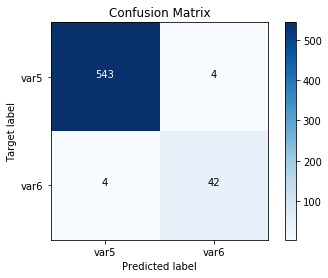

EPOCH: 197
TRAIN LOSS: 0.017829599941067687
VAL LOSS: 0.09672631124108036
VAL ACCURACY: 99.1 %
TIME: 15.2 s


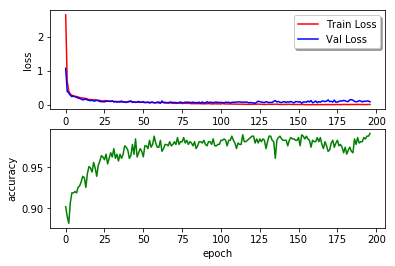

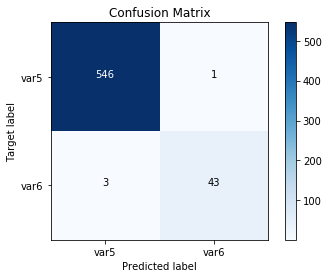

EPOCH: 198
TRAIN LOSS: 0.015546752849666551
VAL LOSS: 0.13656744089177975
VAL ACCURACY: 98.3 %
TIME: 15.2 s


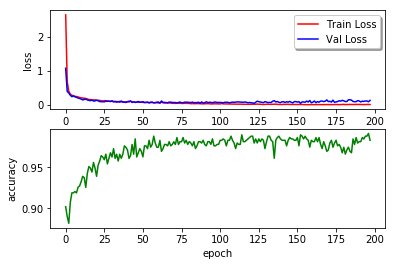

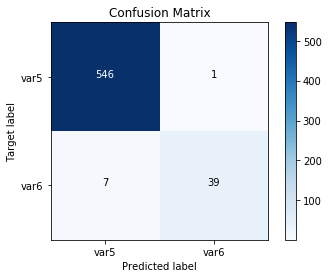

EPOCH: 199
TRAIN LOSS: 0.016671948580449347
VAL LOSS: 0.12335056950879411
VAL ACCURACY: 98.6 %
TIME: 16.2 s


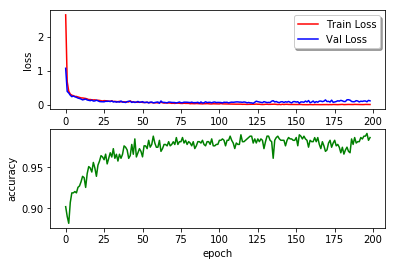

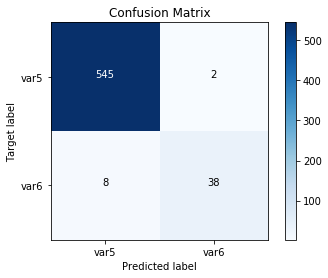

EPOCH: 200
TRAIN LOSS: 0.011768503503049185
VAL LOSS: 0.09811414100240497
VAL ACCURACY: 98.9 %
TIME: 16.6 s


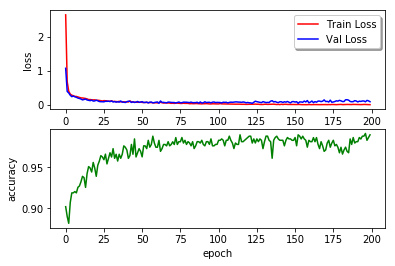

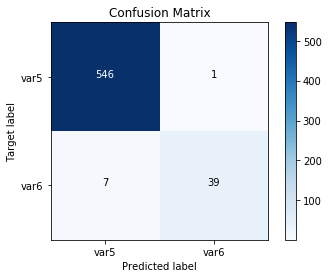

EPOCH: 201
TRAIN LOSS: 0.011488810342924528
VAL LOSS: 0.11141832028021004
VAL ACCURACY: 98.9 %
TIME: 20.8 s


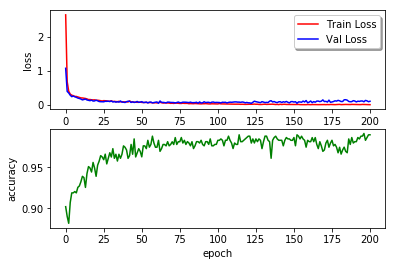

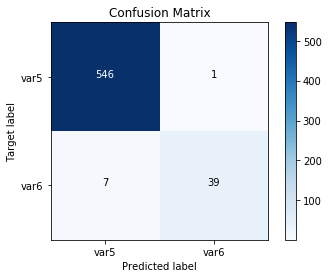

EPOCH: 202
TRAIN LOSS: 0.006682756737112725
VAL LOSS: 0.10592637464390248
VAL ACCURACY: 98.8 %
TIME: 18.2 s


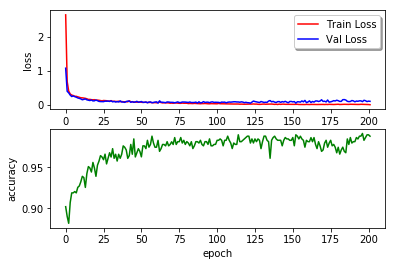

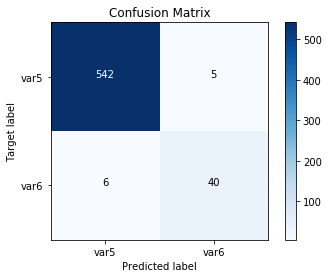

EPOCH: 203
TRAIN LOSS: 0.005577852614982039
VAL LOSS: 0.09699072134537653
VAL ACCURACY: 98.8 %
TIME: 22.3 s


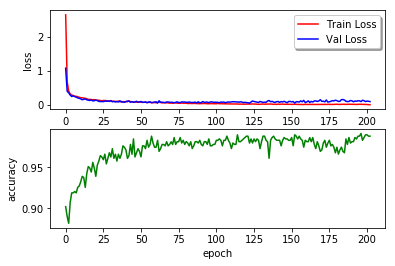

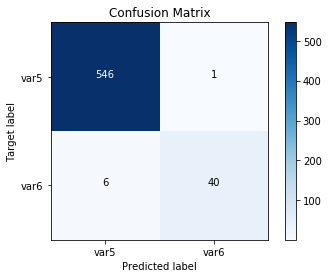

EPOCH: 204
TRAIN LOSS: 0.009294053742184463
VAL LOSS: 0.12880757962075212
VAL ACCURACY: 99.1 %
TIME: 15.5 s


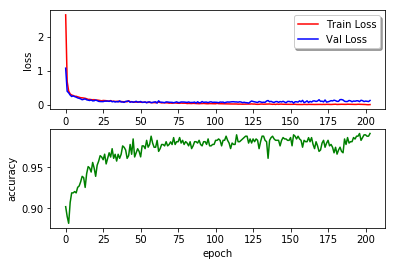

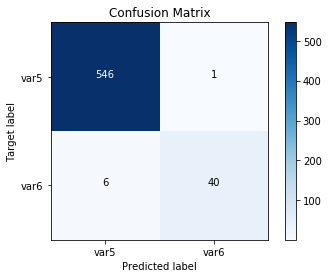

EPOCH: 205
TRAIN LOSS: 0.007598916935580905
VAL LOSS: 0.12394946876958265
VAL ACCURACY: 99.1 %
TIME: 16.0 s


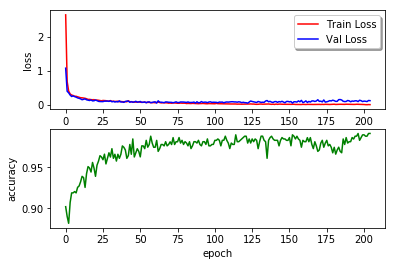

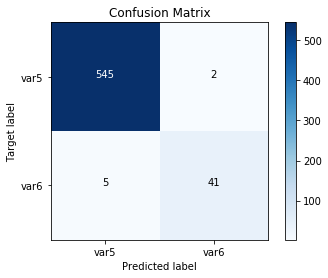

EPOCH: 206
TRAIN LOSS: 0.00870923404223278
VAL LOSS: 0.08932520773846389
VAL ACCURACY: 98.6 %
TIME: 27.8 s


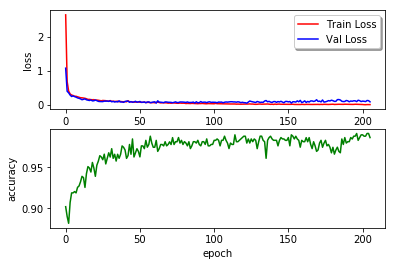

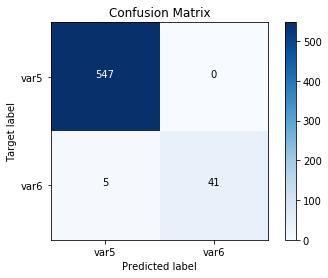

EPOCH: 207
TRAIN LOSS: 0.0040696681080302916
VAL LOSS: 0.10411387242877673
VAL ACCURACY: 98.9 %
TIME: 20.6 s


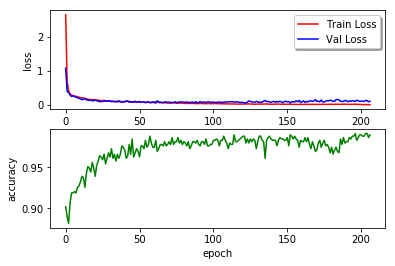

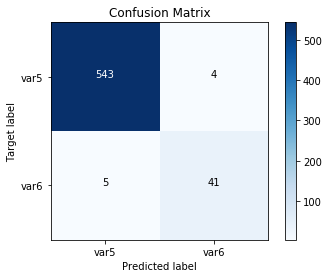

EPOCH: 208
TRAIN LOSS: 0.003933280019898243
VAL LOSS: 0.11476471061425011
VAL ACCURACY: 98.4 %
TIME: 17.4 s


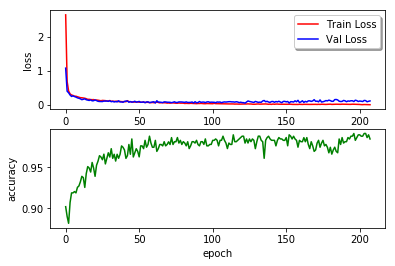

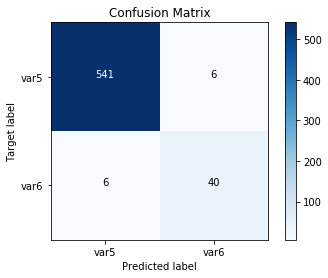

EPOCH: 209
TRAIN LOSS: 0.007922412265434213
VAL LOSS: 0.10914920630139445
VAL ACCURACY: 98.8 %
TIME: 20.4 s


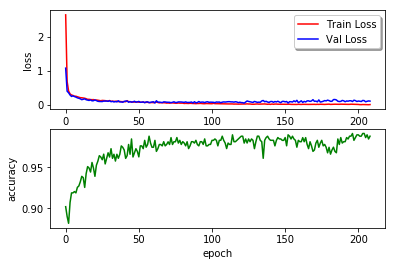

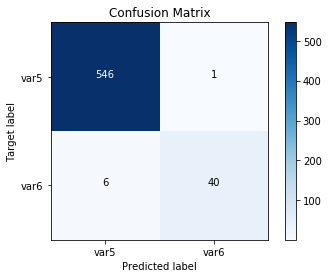

EPOCH: 210
TRAIN LOSS: 0.005971846358118416
VAL LOSS: 0.11675744953871124
VAL ACCURACY: 98.8 %
TIME: 26.5 s


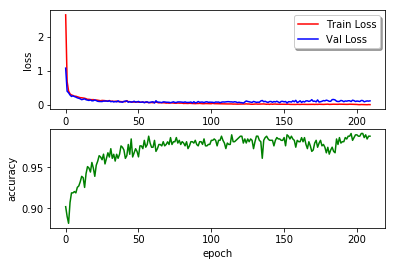

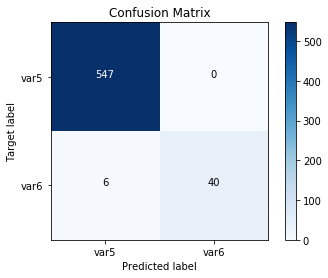

EPOCH: 211
TRAIN LOSS: 0.004118907207271823
VAL LOSS: 0.08412029710550521
VAL ACCURACY: 98.4 %
TIME: 22.8 s


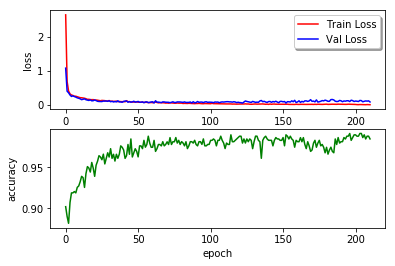

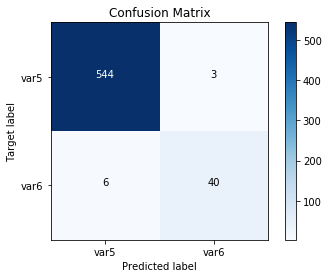

EPOCH: 212
TRAIN LOSS: 0.007079176052023446
VAL LOSS: 0.1291265150958632
VAL ACCURACY: 98.6 %
TIME: 15.8 s


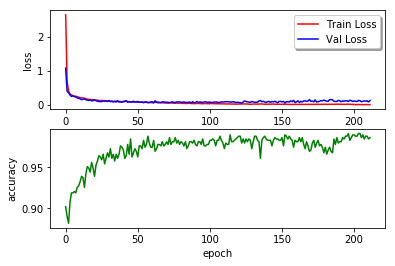

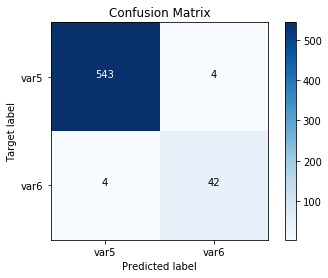

EPOCH: 213
TRAIN LOSS: 0.006978773645735233
VAL LOSS: 0.11242526423481065
VAL ACCURACY: 98.9 %
TIME: 15.7 s


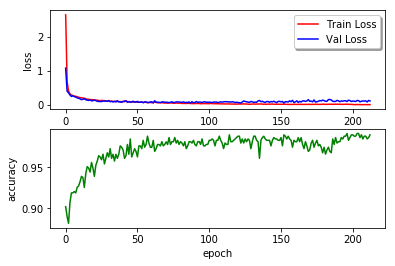

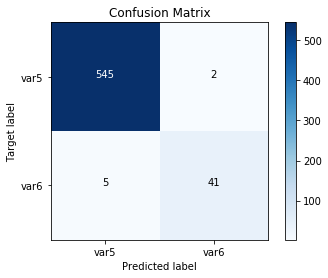

EPOCH: 214
TRAIN LOSS: 0.004138616300975522
VAL LOSS: 0.15576064955757224
VAL ACCURACY: 98.3 %
TIME: 15.5 s


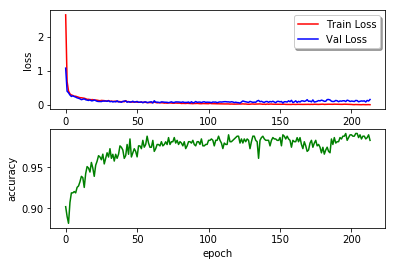

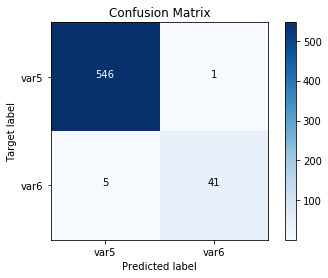

EPOCH: 215
TRAIN LOSS: 0.004799292964032823
VAL LOSS: 0.15036154804067803
VAL ACCURACY: 98.6 %
TIME: 16.4 s


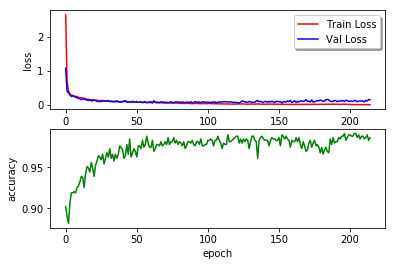

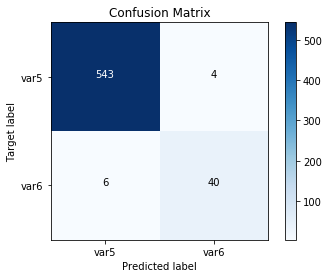

EPOCH: 216
TRAIN LOSS: 0.008681580148142425
VAL LOSS: 0.1272287422067792
VAL ACCURACY: 98.6 %
TIME: 16.3 s


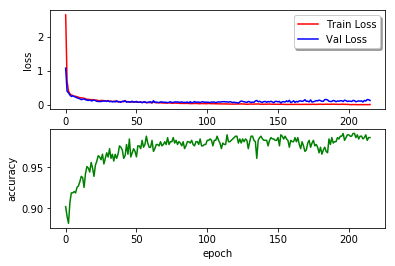

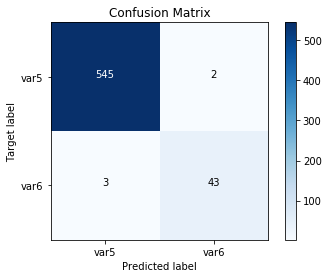

EPOCH: 217
TRAIN LOSS: 0.012291279034143504
VAL LOSS: 0.0970113632112469
VAL ACCURACY: 98.8 %
TIME: 15.4 s


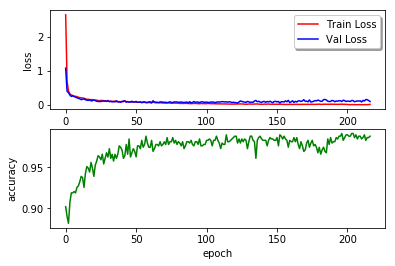

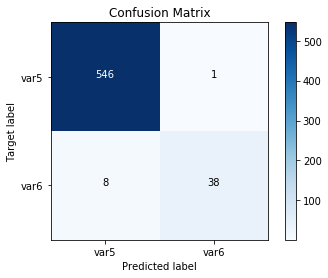

EPOCH: 218
TRAIN LOSS: 0.006626579506544689
VAL LOSS: 0.14168825616517372
VAL ACCURACY: 98.8 %
TIME: 15.7 s


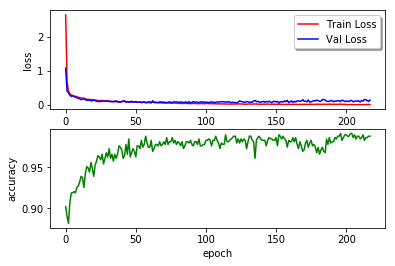

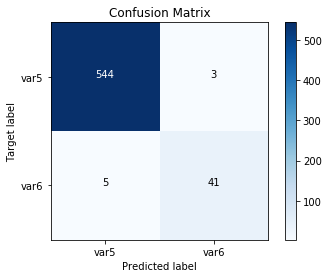

EPOCH: 219
TRAIN LOSS: 0.004575441890600857
VAL LOSS: 0.16199975643608966
VAL ACCURACY: 98.3 %
TIME: 15.0 s


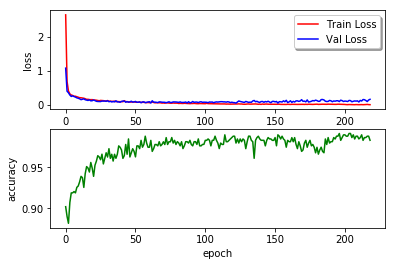

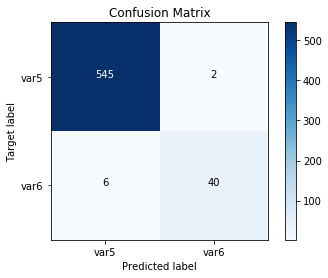

EPOCH: 220
TRAIN LOSS: 0.005733150802029327
VAL LOSS: 0.09892515874939874
VAL ACCURACY: 98.9 %
TIME: 15.4 s


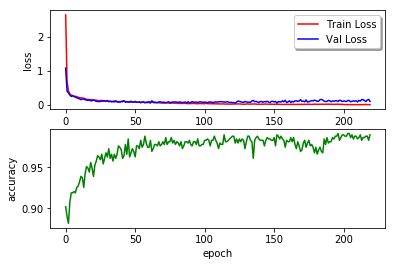

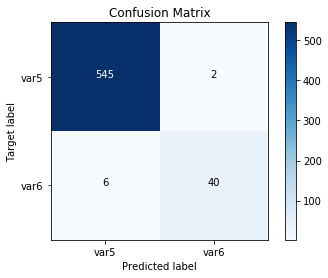

EPOCH: 221
TRAIN LOSS: 0.006566913783193584
VAL LOSS: 0.11909927410899065
VAL ACCURACY: 99.1 %
TIME: 15.6 s


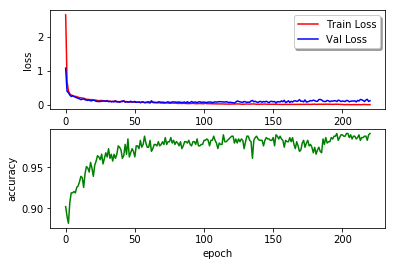

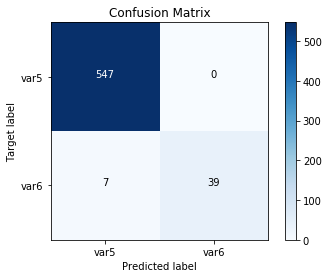

EPOCH: 222
TRAIN LOSS: 0.012615764327141829
VAL LOSS: 0.10895259980325464
VAL ACCURACY: 99.1 %
TIME: 15.3 s


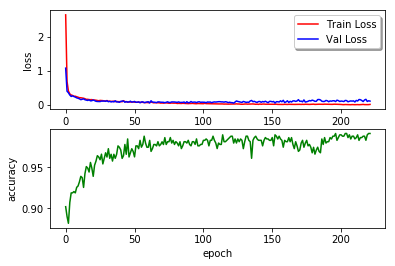

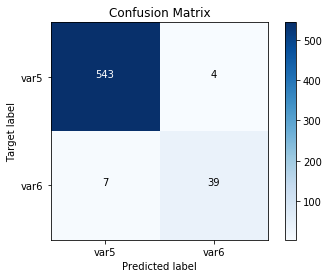

EPOCH: 223
TRAIN LOSS: 0.005142257826020731
VAL LOSS: 0.10135066503484877
VAL ACCURACY: 98.6 %
TIME: 14.9 s


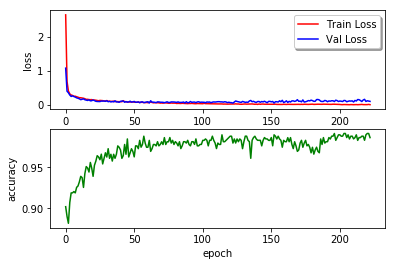

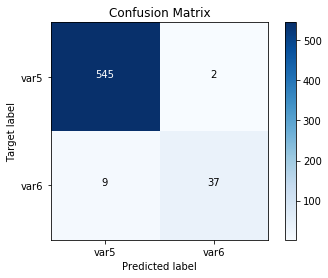

EPOCH: 224
TRAIN LOSS: 0.0066635170207705405
VAL LOSS: 0.15570212955564044
VAL ACCURACY: 98.4 %
TIME: 14.7 s


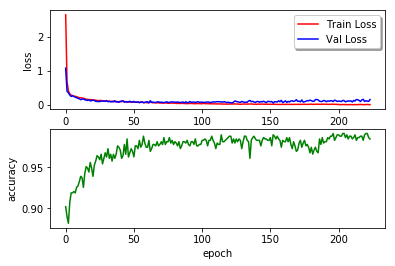

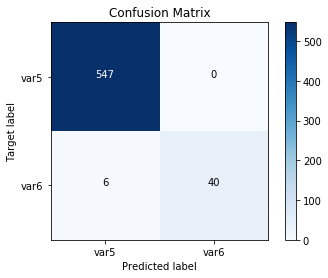

EPOCH: 225
TRAIN LOSS: 0.006003782772849756
VAL LOSS: 0.1401232529791076
VAL ACCURACY: 98.6 %
TIME: 15.0 s


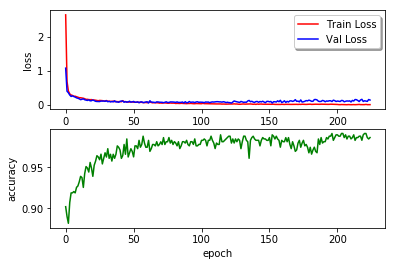

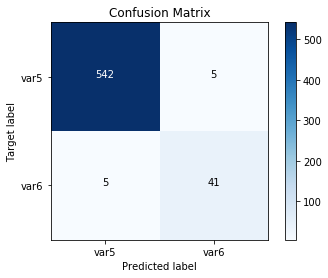

EPOCH: 226
TRAIN LOSS: 0.0029282816794467354
VAL LOSS: 0.12683303479064284
VAL ACCURACY: 98.6 %
TIME: 15.7 s


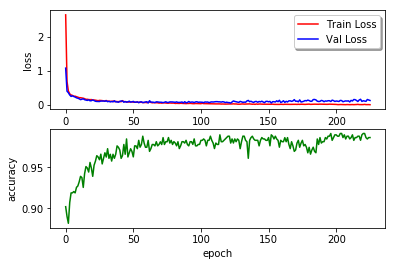

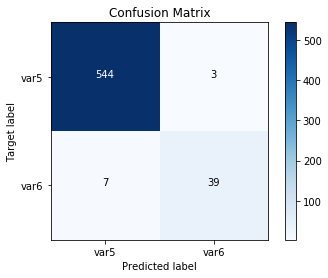

EPOCH: 227
TRAIN LOSS: 0.0032759979160704965
VAL LOSS: 0.11701946016824996
VAL ACCURACY: 98.9 %
TIME: 14.6 s


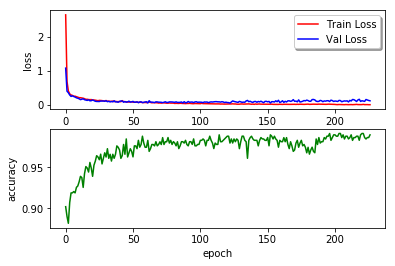

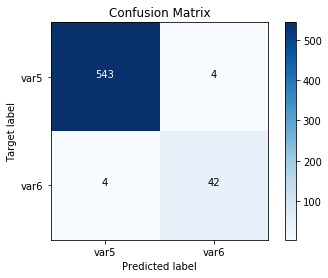

EPOCH: 228
TRAIN LOSS: 0.0049692520834900104
VAL LOSS: 0.10838227413552005
VAL ACCURACY: 98.8 %
TIME: 14.6 s


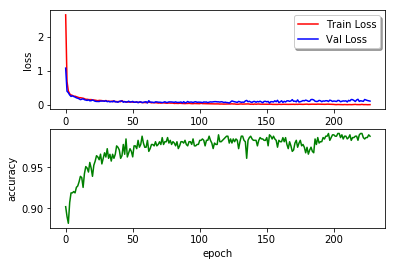

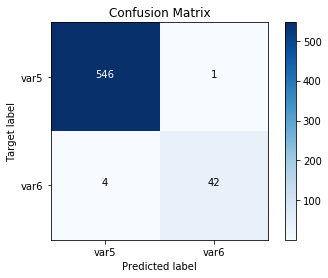

EPOCH: 229
TRAIN LOSS: 0.0035742232619407634
VAL LOSS: 0.14612830522138762
VAL ACCURACY: 99.1 %
TIME: 14.5 s


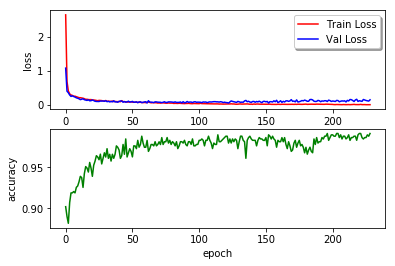

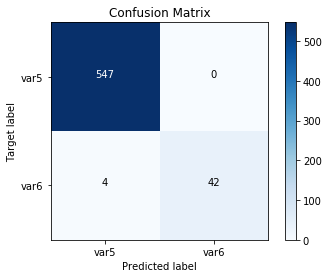

EPOCH: 230
TRAIN LOSS: 0.006287302062880183
VAL LOSS: 0.09233337975267267
VAL ACCURACY: 98.8 %
TIME: 14.5 s


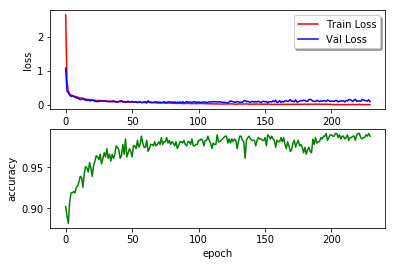

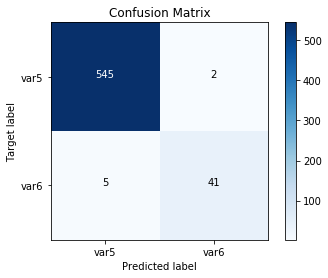

EPOCH: 231
TRAIN LOSS: 0.0044467405650452435
VAL LOSS: 0.07878124993994978
VAL ACCURACY: 98.8 %
TIME: 14.5 s


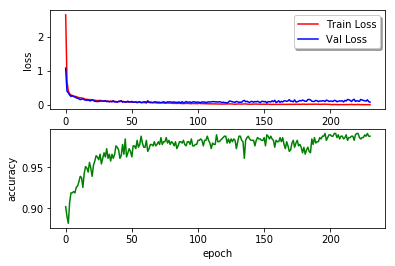

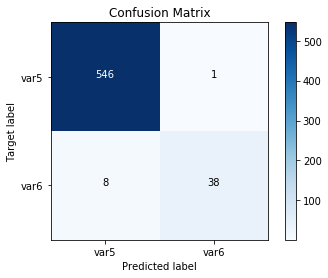

EPOCH: 232
TRAIN LOSS: 0.005783937129357276
VAL LOSS: 0.12570109498807908
VAL ACCURACY: 98.9 %
TIME: 14.7 s


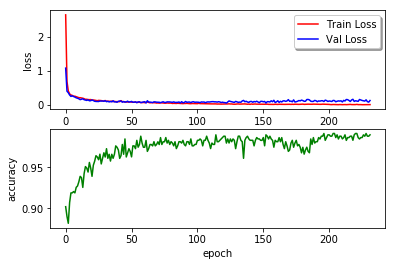

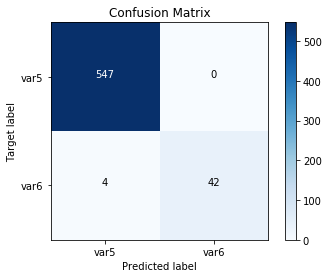

EPOCH: 233
TRAIN LOSS: 0.004007199973719724
VAL LOSS: 0.12746459402147967
VAL ACCURACY: 98.1 %
TIME: 14.6 s


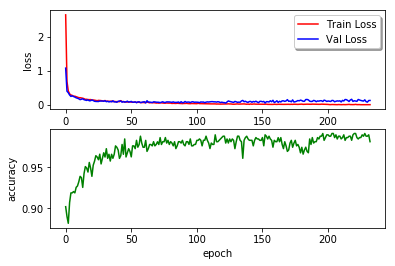

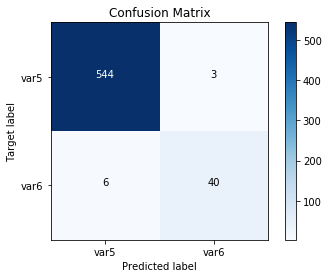

EPOCH: 234
TRAIN LOSS: 0.0037115315524864183
VAL LOSS: 0.15831045297924243
VAL ACCURACY: 98.3 %
TIME: 14.5 s


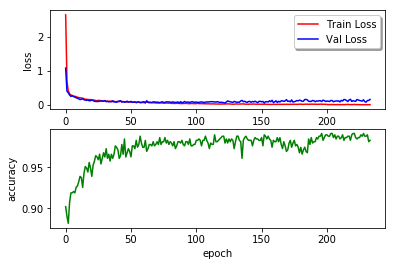

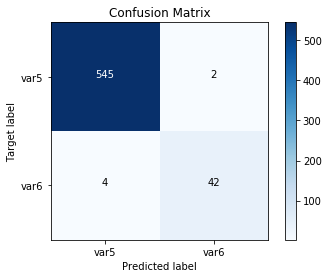

EPOCH: 235
TRAIN LOSS: 0.0024669413735219398
VAL LOSS: 0.1276983357510103
VAL ACCURACY: 98.8 %
TIME: 14.6 s


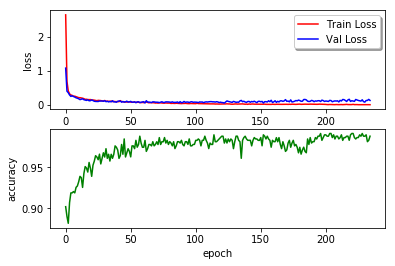

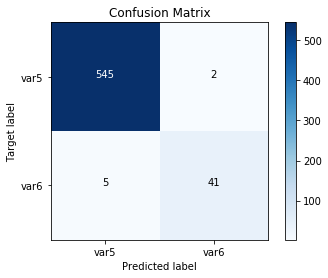

EPOCH: 236
TRAIN LOSS: 0.00395268677163332
VAL LOSS: 0.1178003495587203
VAL ACCURACY: 99.1 %
TIME: 14.6 s


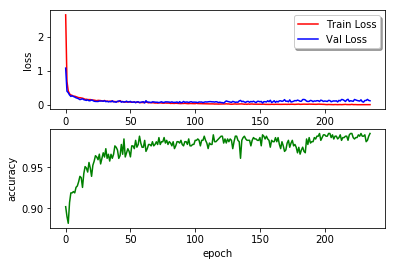

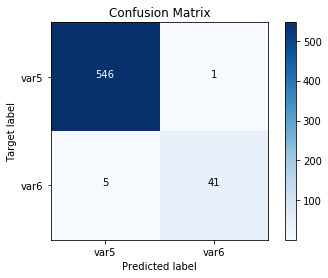

EPOCH: 237
TRAIN LOSS: 0.003529295057348173
VAL LOSS: 0.1364820230058467
VAL ACCURACY: 99.1 %
TIME: 14.5 s


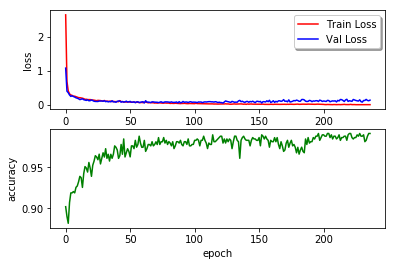

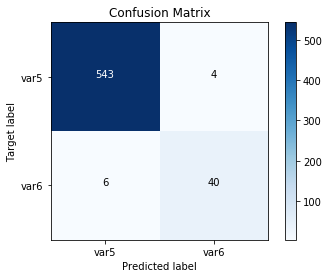

EPOCH: 238
TRAIN LOSS: 0.004814547836167738
VAL LOSS: 0.11383845459501793
VAL ACCURACY: 98.4 %
TIME: 14.5 s


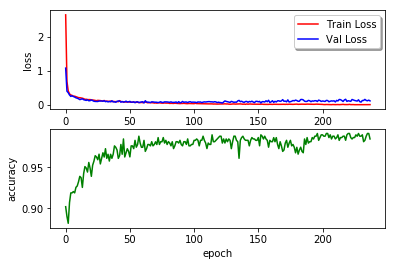

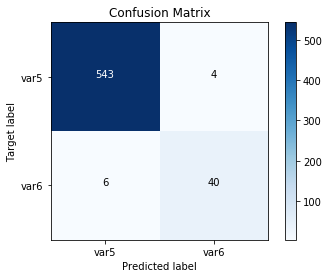

EPOCH: 239
TRAIN LOSS: 0.006030701210957286
VAL LOSS: 0.15159551673550375
VAL ACCURACY: 98.9 %
TIME: 14.5 s


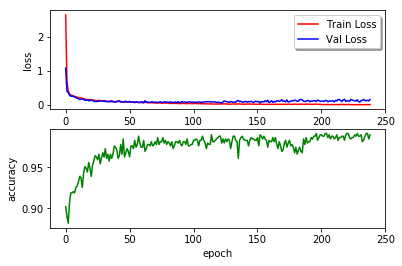

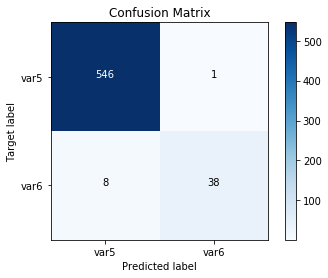

EPOCH: 240
TRAIN LOSS: 0.005154487085045099
VAL LOSS: 0.09427913473576885
VAL ACCURACY: 98.9 %
TIME: 14.9 s


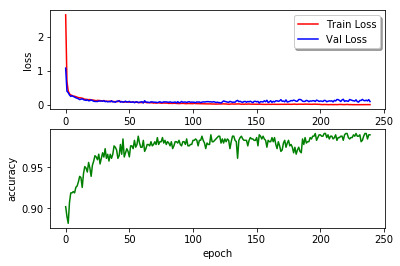

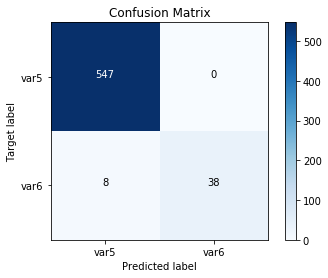

EPOCH: 241
TRAIN LOSS: 0.005563908777716373
VAL LOSS: 0.16293001597804108
VAL ACCURACY: 98.8 %
TIME: 16.4 s


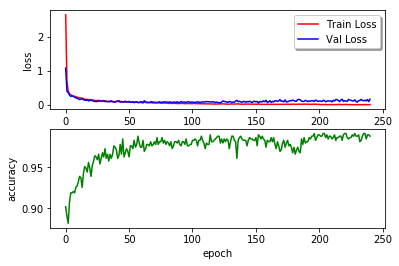

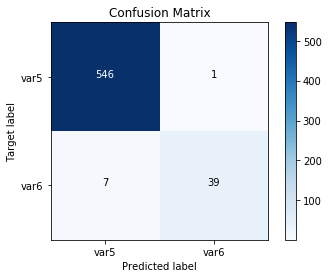

EPOCH: 242
TRAIN LOSS: 0.0063900498522526765
VAL LOSS: 0.12939524586188822
VAL ACCURACY: 98.8 %
TIME: 17.4 s


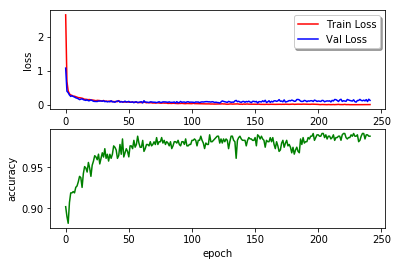

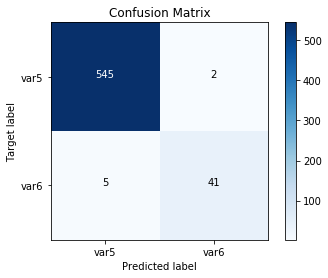

EPOCH: 243
TRAIN LOSS: 0.004103108946313635
VAL LOSS: 0.125598184634428
VAL ACCURACY: 98.6 %
TIME: 15.8 s


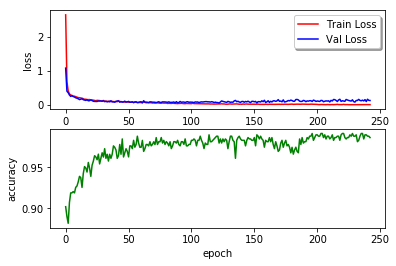

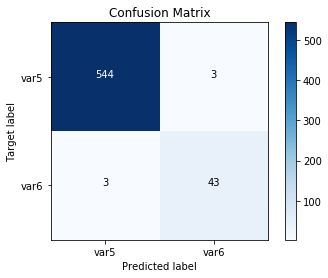

EPOCH: 244
TRAIN LOSS: 0.005454217961505142
VAL LOSS: 0.09831550630846964
VAL ACCURACY: 98.9 %
TIME: 17.6 s


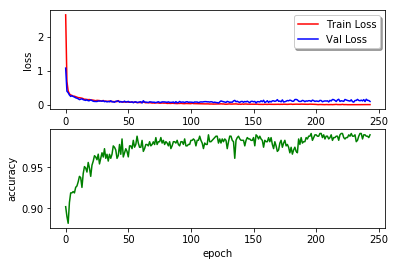

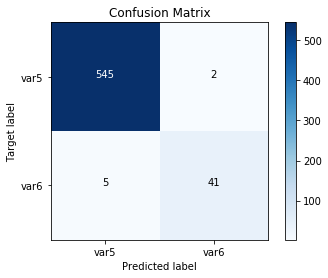

EPOCH: 245
TRAIN LOSS: 0.003989406860080058
VAL LOSS: 0.09196811558455237
VAL ACCURACY: 98.3 %
TIME: 19.4 s


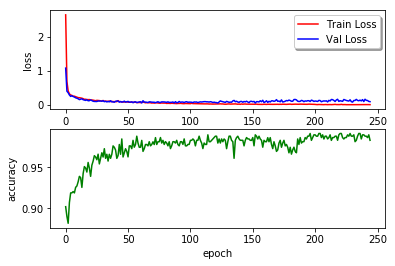

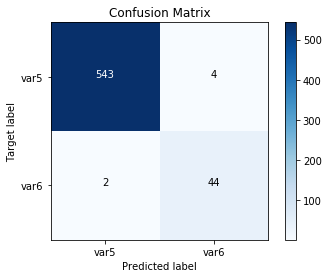

EPOCH: 246
TRAIN LOSS: 0.007127750988287699
VAL LOSS: 0.10204969405769597
VAL ACCURACY: 97.9 %
TIME: 19.8 s


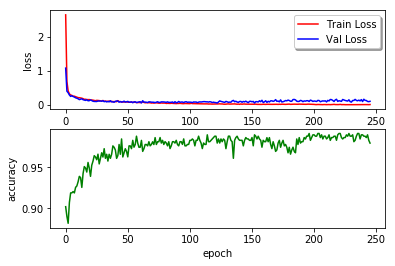

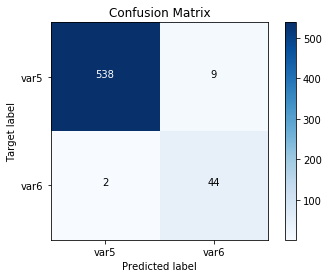

EPOCH: 247
TRAIN LOSS: 0.005836213138517173
VAL LOSS: 0.11578521326334648
VAL ACCURACY: 98.9 %
TIME: 20.5 s


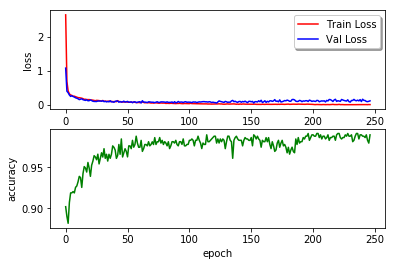

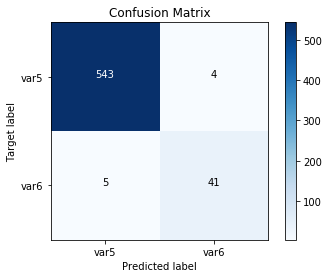

EPOCH: 248
TRAIN LOSS: 0.003617837478003187
VAL LOSS: 0.12392783180973055
VAL ACCURACY: 98.9 %
TIME: 20.7 s


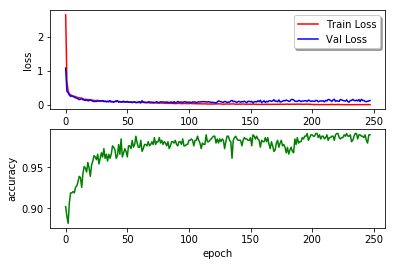

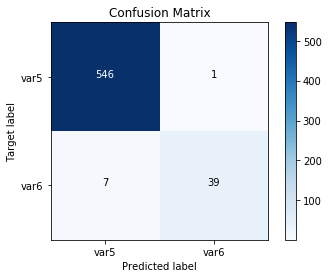

EPOCH: 249
TRAIN LOSS: 0.003857795542917754
VAL LOSS: 0.1309541642960264
VAL ACCURACY: 98.8 %
TIME: 21.9 s


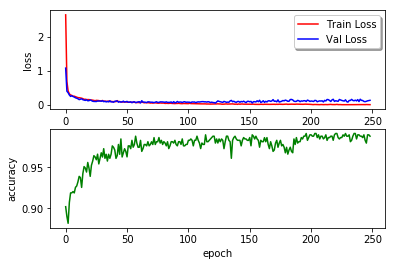

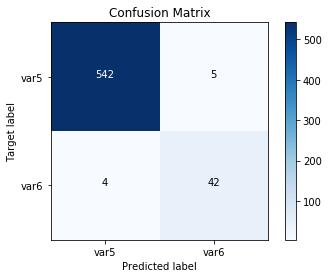

BEST VAL ACCURACY: 99.1 % EPOCH: 204
Final results:
  test loss:			0.105760
  test accuracy:		97.97 %
TRAINING DONE!


In [15]:
import time
import sklearn
import numpy 
import matplotlib.pyplot as plt
import numpy as np
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,250):
 
    #start timer
    start = time.time()
    
    #reset confusion matrix
    clearConfusionMatrix()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
         
        #save predicions and targets for confusion matrix
        
        updateConfusionMatrix(target_batch,prediction_batch)
    
    #mlxtend confusion matrix
    #cm=confusion_matrix(target_batch,prediction_batch)
    #    fig,ax=plot_confusion_matrix(conf_mat=cm)
      #  plt.show()
        
        #pandas_ml confusion matrix
        #confusion_matrix1 = ConfusionMatrix(target_batch,prediction_batch)
        #print("Confusion matrix:\n%s" % confusion_matrix1)
        
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
    
    #show confusion matrix
    showConfusionMatrix()

    #show best accuracy and epoch
print ("BEST VAL ACCURACY:", (int(max(val_accuracy) * 1000) / 10.0), "%", "EPOCH:", val_accuracy.index(max(val_accuracy)) + 1)

#####TESTING DATA#######
test_err = 0
test_acc = 0
test_batches = 0
for image_batch, target_batch in getNextImageBatch1():
    test_batch, err, acc = test_net(image_batch, target_batch)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
print ("TRAINING DONE!") 

In [73]:
from sklearn.utils.class_weight import compute_sample_weight
y =  ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
compute_sample_weight(class_weight='unbalanced', y=y)

array([1., 1., 1., 1., 1., 1., 1.])

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')